In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from tqdm import tqdm, trange, tqdm_notebook

from matplotlib.pylab import get_cmap
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import scipy as sp
import sys, os
try:
    import cPickle as pickle
except:
    import pickle
from glob import glob

fs=20
fs_ticks = 16

from scipy.stats import norm

# define sfb colors
colors = ['#3850A1', '#F79645', '#993A91']
#new trial
colors = ['#0D589A', '#5DB5D0', '#A9DBB7','blue']

from matplotlib.ticker import (AutoMinorLocator, FixedLocator, FuncFormatter,
                               MultipleLocator, NullLocator, LogLocator)
import healpy as hp

from scipy.interpolate import UnivariateSpline
from matplotlib.lines import Line2D


from scipy.interpolate import splrep, splev
from copy import deepcopy 

#from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
from PyAstronomy import pyasl

from astropy import units as u
from astropy.coordinates import SkyCoord

from tools import *
from tools import _trans

# define binning on skymap

In [9]:
NSIDE = 2**6
npix = hp.nside2npix(NSIDE)

ngrid=500


# this gives the pixel size in sterradian (also called square radian)
psize = hp.nside2pixarea(NSIDE)
print(npix*psize, 4*np.pi)

12.566370614359172 12.566370614359172


# use mceq for the background flux estimation

In [10]:
import mceq_config as config
from MCEq.core import MCEqRun
import crflux.models as pm

199MB [00:18, 10.5MB/s]                          


In [11]:
config.e_min = 1#86e-3
config.e_max = 1e9#1e11
config.debug_level = 2
config.enable_em = False
config.mkl_threads = 32
config.hybrid_crossover = 0.5

In [12]:
base_model = 'SIBYLL23C'
mceq = MCEqRun(
    interaction_model=base_model,
    theta_deg=0.,
    primary_model=(
        pm.GlobalSplineFitBeta,
        '/Users/mhuber/AtmosphericShowers/Data/GSF_spline_20171007.pkl.bz2'
    )
)

HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): SIBYLL23C
HDF5Backend::decay_db(): Using helicity dependent decays.


IndexError: index 0 is out of bounds for axis 0 with size 0

In [9]:
mag = 0


#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(1,0,1))*180./np.pi

flux_def = dict()
#Initialize empty grid
for frac in ['numu_conv','numu_pr','numu_total',
             'mu_conv','mu_pr','mu_total',
             'nue_conv','nue_pr','nue_total','nutau_pr']:
    flux_def[frac] = np.zeros_like(mceq.e_grid)

    
#Sum fluxes, calculated for different angles
for theta in angles:
    mceq.set_theta_deg(theta)
    mceq.solve()
    
    # same meaning of prefixes for muon neutrinos as for muons
    flux_def['mu_conv'] += (mceq.get_solution('conv_mu+', mag)
                         + mceq.get_solution('conv_mu-', mag))

    flux_def['mu_pr'] += (mceq.get_solution('pr_mu+', mag)
                       + mceq.get_solution('pr_mu-', mag))

    flux_def['mu_total'] += (mceq.get_solution('total_mu+', mag)
                          + mceq.get_solution('total_mu-', mag))
    
    
    # same meaning of prefixes for muon neutrinos as for muons
    flux_def['numu_conv'] += (mceq.get_solution('conv_numu', mag)
                         + mceq.get_solution('conv_antinumu', mag))

    flux_def['numu_pr'] += (mceq.get_solution('pr_numu', mag)
                       + mceq.get_solution('pr_antinumu', mag))

    flux_def['numu_total'] += (mceq.get_solution('total_numu', mag)
                          + mceq.get_solution('total_antinumu', mag))

    # same meaning of prefixes for electron neutrinos as for muons
    flux_def['nue_conv'] += (mceq.get_solution('conv_nue', mag)
                        + mceq.get_solution('conv_antinue', mag))

    flux_def['nue_pr'] += (mceq.get_solution('pr_nue', mag)
                      + mceq.get_solution('pr_antinue', mag))

    flux_def['nue_total'] += (mceq.get_solution('total_nue', mag)
                         + mceq.get_solution('total_antinue', mag))


    # since there are no conventional tau neutrinos, prompt=total
    flux_def['nutau_pr'] += (mceq.get_solution('total_nutau', mag)
                        + mceq.get_solution('total_antinutau', mag))

#average the results
for frac in [
             'numu_conv','numu_pr','numu_total',
            'mu_conv','mu_pr','mu_total',
             'nue_conv','nue_pr','nue_total','nutau_pr']:
    flux_def[frac] = flux_def[frac]/float(len(angles))



MCEqRun::set_theta_deg(): Zenith angle   0.00
MCEqRun::set_theta_deg(): Theta selection correponds to cached value, skipping calc.
MCEqRun::solve(): Launching euler solver
MCEqRun::_calculate_integration_path(): X_surface = 1033.81g/cm2
MCEqRun::solve(): for 451 integration steps.
solv_numpy(): Performance:   3.69ms/iteration
MCEqRun::solve(): time elapsed during integration:  1.68sec


# Show the background spectrum

<IPython.core.display.Javascript object>


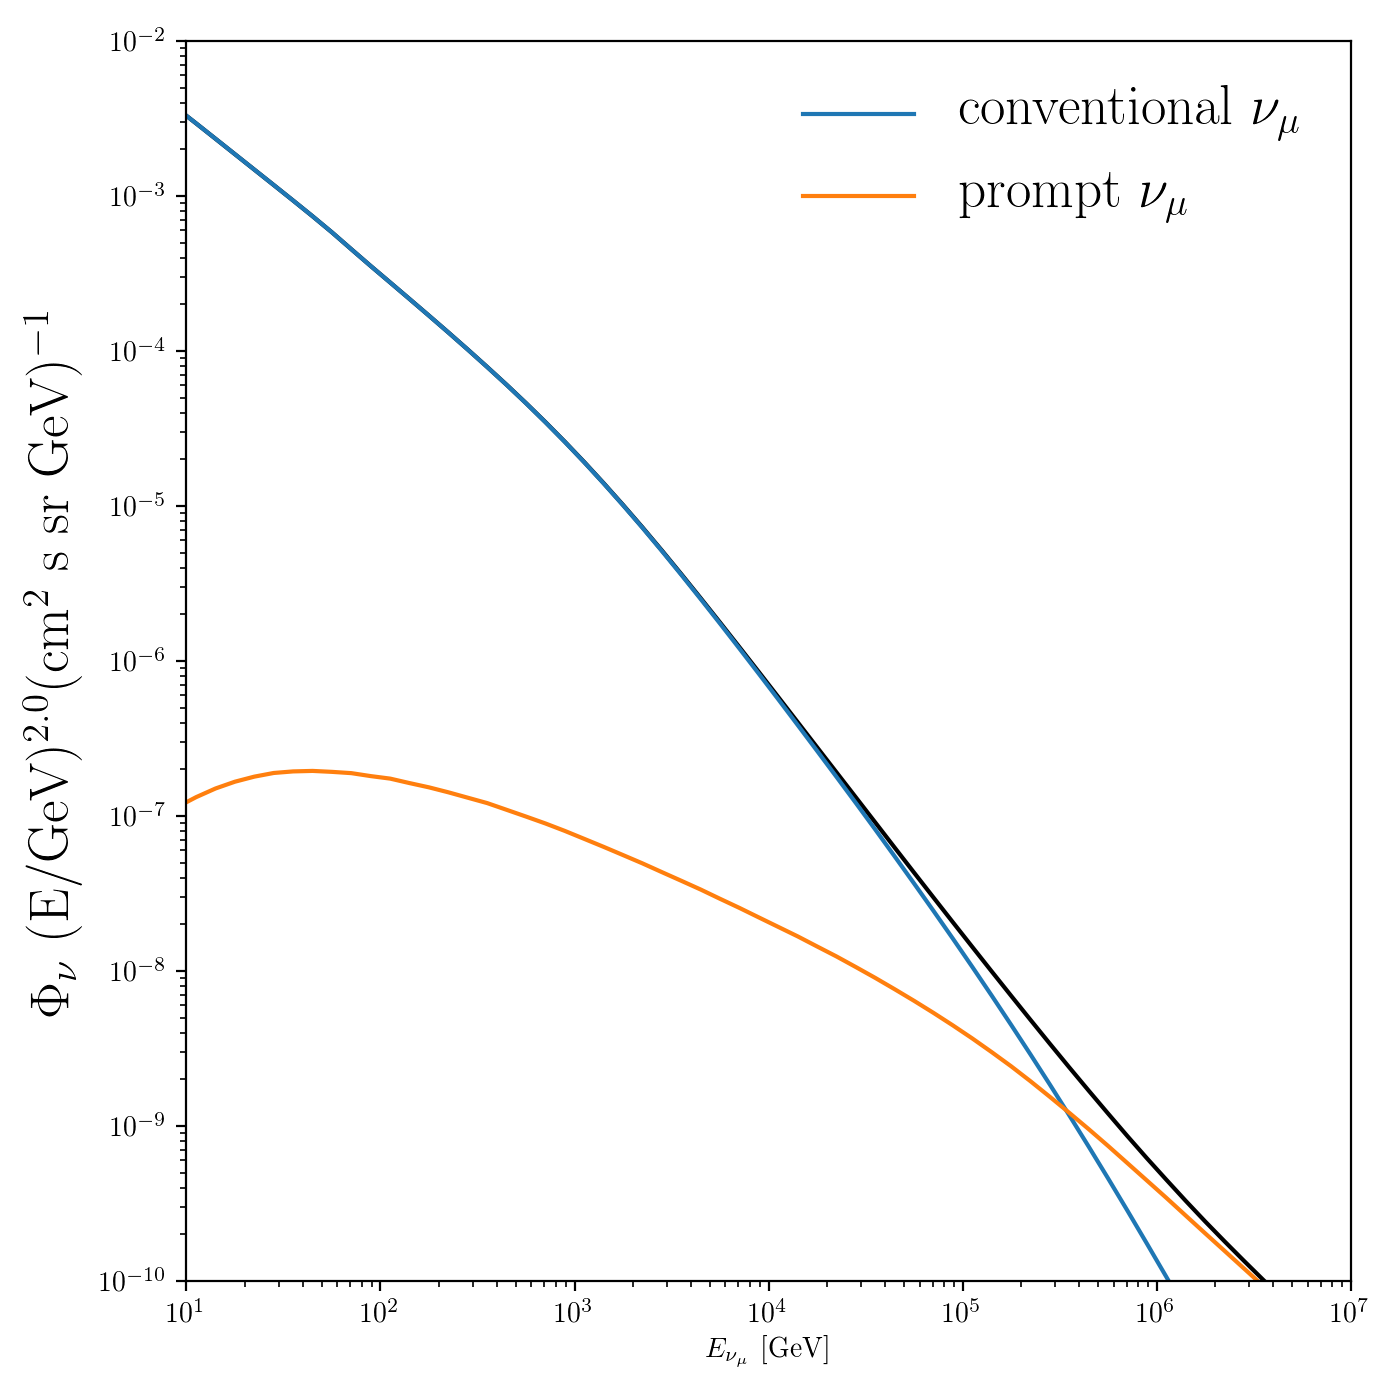

In [10]:
fig, ax = plt.subplots( figsize=(7,7))
e_grid = mceq.e_grid

spec = 2.
for i,(pref, lab) in enumerate([('numu_',r'\nu_\mu')]):
    
    p0 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'total'], color='k', ls='solid', lw=1.5)
    p1 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'conv'],  ls='solid', lw=1.5,
               label=r'conventional ${0}$'.format(lab))
    p2 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'pr'], ls='solid', lw=1.5, 
               label='prompt ${0}$'.format(lab))
    
    
    
    ax.set_xlim(10,1e7)
    
    ax.set_ylim(1e-10,1e-2)
    #ax.set_ylim(0.8,1.2)
    ax.set_xlabel(r"$E_{{{0}}}$ [GeV]".format(lab))
    
    ax.legend(loc='upper right',frameon=False,numpoints=1,fontsize=fs)

ax.set_ylabel(r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) +" }$" + 
           "(cm$^{2}$ s sr GeV)$^{-1}$", fontsize=fs)
    
    

fig.tight_layout()

# Now use the effective areas that i created for plenum to get signal and background event number descriptions

In [11]:
path = '/Users/mhuber/Documents/Papers/Plenum/'
results = np.load(os.path.join(path, 'effective_areas_av_per_day.npy'))

<IPython.core.display.Javascript object>


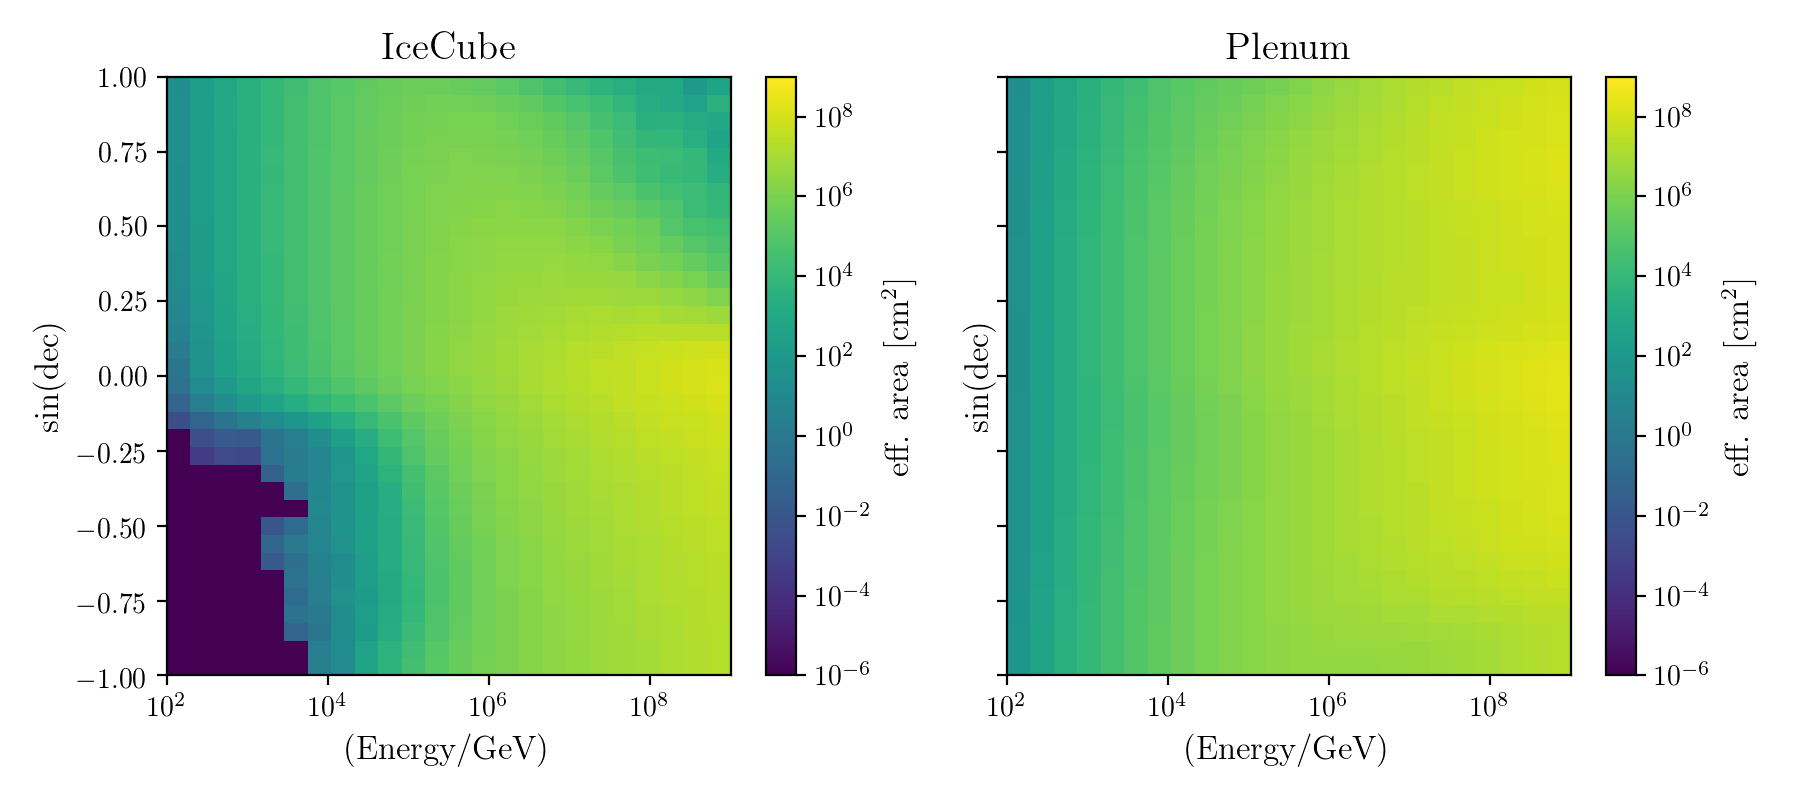

In [12]:
e_bins = np.linspace(2.,9.,num=25)
e_mids = 10**get_mids(e_bins)
e_bins = 10**e_bins

sd_bins = np.linspace(-1.,1.,35)
n_sd, n_e = len(sd_bins)-1, len(e_bins)-1

ebin_width = np.diff(e_bins)

# get the mceq flux values within the respective energy bins
ind_mceq = [np.argmin(np.abs(mceq.e_grid-ei)) for ei in e_mids]


fig, axes=plt.subplots(ncols=2, figsize=(9,4), sharey=True)

ax = axes[0]
ax.set_title('IceCube', fontsize=14)
p = ax.pcolormesh(e_bins, sd_bins, #Res_effA*1e4
                  results['effA_icecube'].reshape((n_sd, n_e)) 
                  , norm=LogNorm(),#, vmin=1e-2)#, 
                  vmax = 1e9, vmin=1e-6)

ax.set_xlabel(r'(Energy/GeV)',fontsize=12)
ax.set_ylabel(r'sin(dec)',fontsize=12)

cb=fig.colorbar(p,ax=ax)
cb.set_label(r'eff. area [cm$^2$]', fontsize=12)
ax.set_xscale('log')

ax = axes[1]
ax.set_title('Plenum', fontsize=14)
p = ax.pcolormesh(e_bins, sd_bins,
                  results['effA_plenum'].reshape((n_sd, n_e))  
                  , norm=LogNorm(),#, vmin=1e-2)#, 
                  vmax = 1e9, vmin=1e-6)

ax.set_xlabel(r'(Energy/GeV)',fontsize=12)
ax.set_ylabel(r'sin(dec)',fontsize=12)

cb=fig.colorbar(p,ax=ax)
cb.set_label(r'eff. area [cm$^2$]', fontsize=12)


ax.set_xscale('log')
fig.tight_layout()
plt.show()

# Now get the background expectations 

In [13]:
from copy import copy

<IPython.core.display.Javascript object>


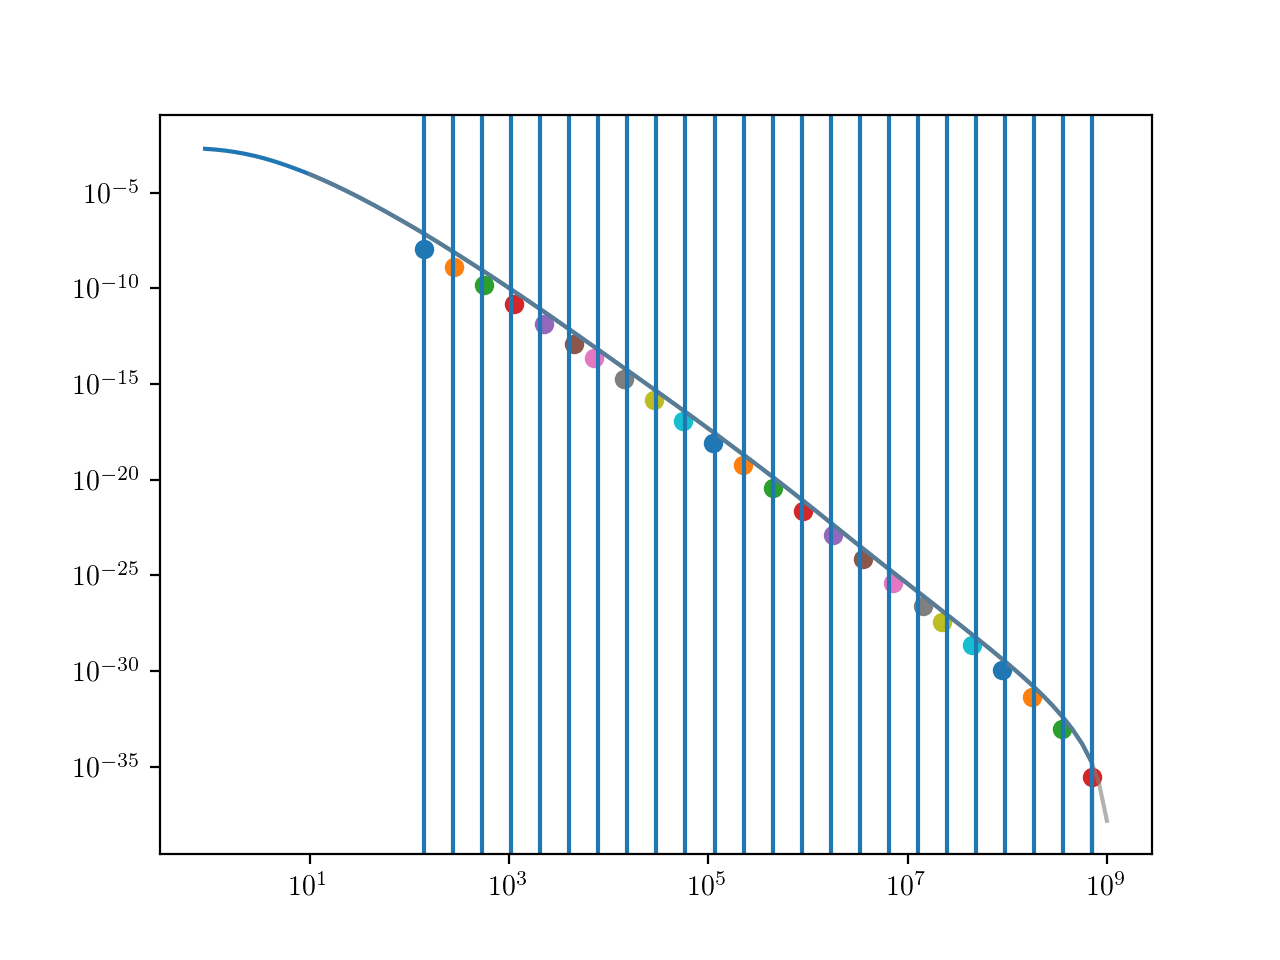

In [14]:
# check the background flux values

fig, ax = plt.subplots()

ax.plot(mceq.e_grid, flux_def['mu_conv'] )


tck = splrep(mceq.e_grid[:-1], np.log(flux_def['mu_conv'])[:-1]  , s=1.e-2)


xvals = 10**np.linspace(1,9,100)
spl_vals = np.exp(splev(xvals, tck)) 
ax.plot(xvals, spl_vals, color='grey', alpha=0.6)

for k,ei in enumerate(e_mids):
    ax.scatter(mceq.e_grid[ind_mceq][k], flux_def['numu_conv'][ind_mceq][k], marker='o')
    ax.axvline(ei)   
ax.set_xscale('log')
ax.set_yscale('log')

In [15]:

Res_mu = dict()
Res_numu = dict()
Res_mu_prompt = dict()
Res_numu_prompt = dict()


tck_numu = splrep(mceq.e_grid, np.log(flux_def['numu_conv'])  , s=1.e-2)
tck_numu_pr = splrep(mceq.e_grid, np.log(flux_def['numu_pr'])  , s=1.e-2)

tck_mu = splrep(mceq.e_grid[:-1], np.log(flux_def['mu_conv'])[:-1]  , s=1.e-2)
tck_mu_pr = splrep(mceq.e_grid[:-1], np.log(flux_def['mu_pr'])[:-1]  , s=1.e-2)

for exp in ['icecube', 'plenum']:
    
    NTOT_numu = np.zeros((n_e,n_sd), dtype=float)
    NTOT_mu = np.zeros((n_e,n_sd), dtype=float)
    NTOT_numu_prompt = np.zeros((n_e,n_sd), dtype=float)
    NTOT_mu_prompt = np.zeros((n_e,n_sd), dtype=float)

    effA = copy(results['effA_'+exp].reshape((n_sd, n_e)))

    for i, sd_i in enumerate(get_mids(sd_bins)):
    
        h_aeff = effA[i]

        for k,ei in enumerate(e_mids):

            
            Ni = np.sum(h_aeff[k] * np.exp(splev(ei, tck_numu))  * ebin_width[k]) 
            
            # flux_def['numu_conv'][ind_mceq][k]
            NTOT_numu[k,i] = Ni
            
            Ni = np.sum(h_aeff[k] * np.exp(splev(ei, tck_numu_pr)) * ebin_width[k])
            #flux_def['numu_pr'][ind_mceq][k] 
            NTOT_numu_prompt[k,i] = Ni

            Ni = np.sum(h_aeff[k] * np.exp(splev(ei, tck_mu)) * ebin_width[k])
            
            #flux_def['mu_conv'][ind_mceq][k]
            NTOT_mu[k,i] = Ni
            
            Ni = np.sum(h_aeff[k] * np.exp(splev(ei, tck_mu_pr)) * ebin_width[k])
            #flux_def['mu_pr'][ind_mceq][k] 
            NTOT_mu_prompt[k,i] = Ni
            
    Res_mu[exp] = NTOT_mu
    Res_numu[exp] = NTOT_numu
    Res_mu_prompt[exp] = NTOT_mu_prompt
    Res_numu_prompt[exp] = NTOT_numu_prompt

# Now also some signal expectations 

In [16]:
def int_powerlaw(gamma, emin, emax):
    if gamma!=1:
        return 1./(1-gamma) * (emax**(1-gamma) - emin**(1-gamma))

    else:
        return np.log(emax/emin)
    
    
from scipy.stats import poisson



use for instance some limit on the diffuse emission from the galaxy from 
https://arxiv.org/pdf/1707.03416.pdf

In [17]:
gamma_gal = 2.5
phi_gal = 3.83e-18 *10**(5*gamma_gal) / (0.1*4*np.pi) # last part accounts for the fraction of the sky covered by gp

In [18]:
ResSig = dict()


for exp in ['icecube', 'plenum']:

    
    NTOT_Sig = np.zeros((n_e,n_sd), dtype=float)
    effA = copy(results['effA_'+exp].reshape((n_sd, n_e)))

    for i, sd_i in enumerate(get_mids(sd_bins)):
    
        h_aeff = effA[i]

        for k,ei in enumerate(e_mids):

            e_bins[k], e_bins[k+1]
            fluxk = phi_gal * int_powerlaw(gamma_gal, e_bins[k], e_bins[k+1] )
            Ni = h_aeff[k] * fluxk
            NTOT_Sig[k,i] = Ni

            
    ResSig[exp] = NTOT_Sig

<IPython.core.display.Javascript object>


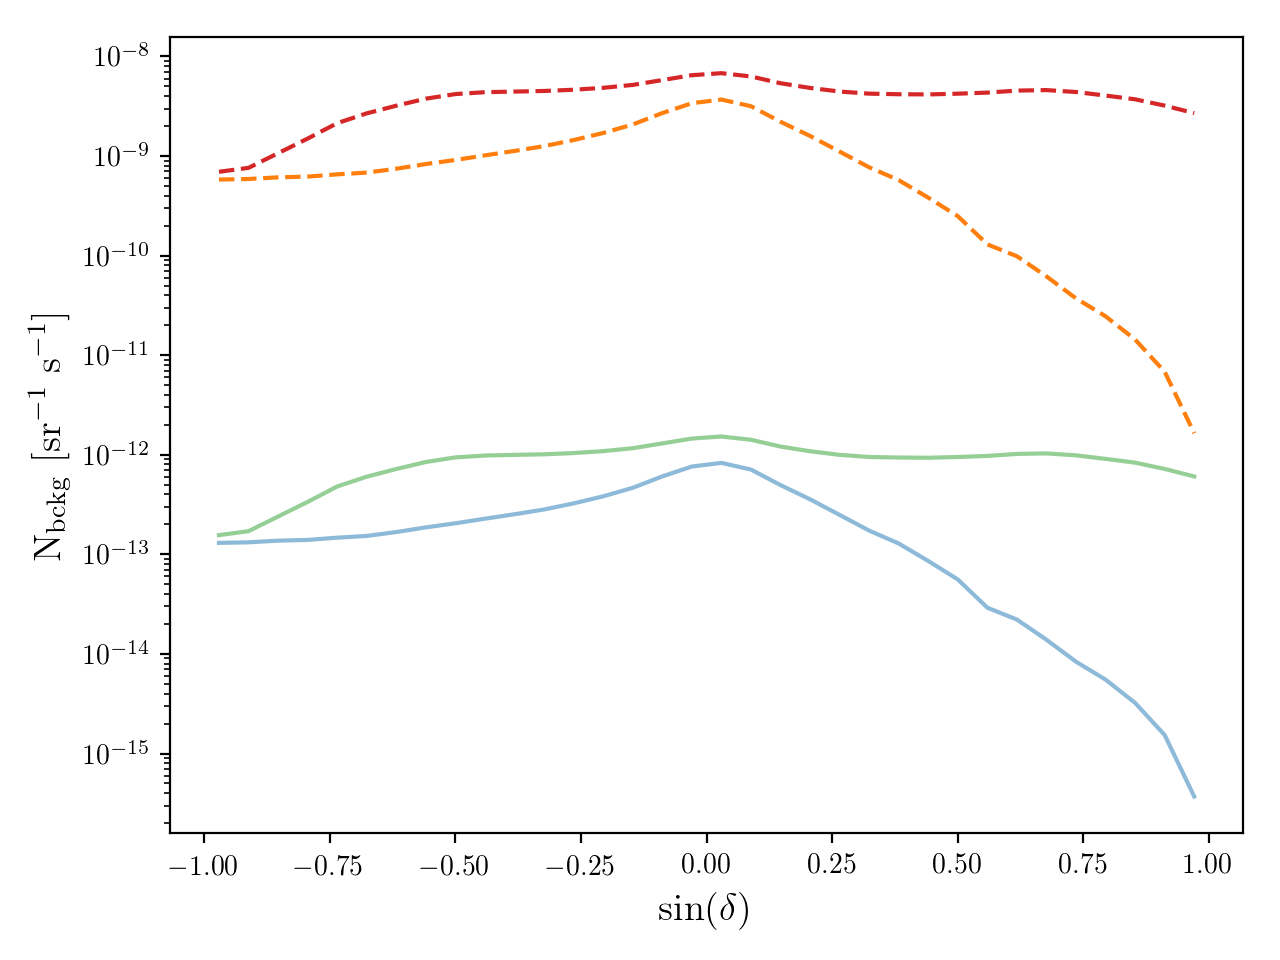

Energy range: 9.09e+06-1.78e+07 GeV
('icecube', 0.000918694750191226, 4.091980503018116)
5.44932166105411e-18
('plenum', 0.003572944033122204, 15.914336420087018)
3.36000092417689e-53


In [19]:
fig, ax = plt.subplots()

lt = 10* 365.25*86400
sr_band = 2*np.pi*np.diff(sd_bins)[0]



evals = [ 1e7]


_is_v2 = [np.argmin(np.abs(e_mids-evi)) for evi in evals] 
lss = ['solid', 'dashed', 'dotted']


NBckg = dict()

xvals = np.linspace(-1,1,500)
for k, i in enumerate(_is_v2):
    
    
    
    #p=ax.plot(sdec_mids, NTot_numu[i], color='blue', ls = lss[k])
    #max_val = np.max(NTot_numu[i])
    #tck = splrep(sdec_mids, NTot_numu[i]/max_val , s=1.e-2)
    #spl_val = splev(xvals, tck)
    
    #ax.plot(xvals, spl_val*max_val, ls='dashed', color=p[0].get_color())
    
    print('Energy range: {0:.2e}-{1:.2e} GeV'.format(e_bins[_is_v2[k]], 
                                                     e_bins[_is_v2[k]+1]))
    
    for exp in ['icecube', 'plenum']:
        if not exp in NBckg.keys():
            NBckg[exp] = 0
        
        ax.plot(get_mids(sd_bins), Res_numu[exp][_is_v2[k]], 
                ls = 'solid', alpha=0.5)
    
    
    
    
        ax.plot(get_mids(sd_bins), ResSig[exp][_is_v2[k]], 
                ls = 'dashed')
        
        nbckg, nsig = np.sum(Res_numu[exp][_is_v2[k]]*lt*sr_band), np.sum(ResSig[exp][_is_v2[k]]*lt*sr_band)
        NBckg[exp] += nbckg
        print(exp, nbckg, nsig)
        print(poisson.sf(int(nbckg+nsig), mu=nbckg))
ax.set_yscale('log')
ax.set_xlabel(r'$\sin (\delta)$',fontsize=14)
ax.set_ylabel(r'N$_{\mathrm{bckg}}$ [sr$^{-1}$ s$^{-1}$]  ',fontsize=14)  #s$^{-1}$]

fig.tight_layout()

In [20]:
NBckg = dict()
NSig = dict()
xvals = np.linspace(-1,1,500)
for k, ei in enumerate(e_mids):
    
    print('Energy range: {0:.2e}-{1:.2e} GeV'.format(e_bins[k], 
                                                     e_bins[k+1]))
    
    
    for exp in ['icecube', 'plenum']:
        if not exp in NBckg.keys():
            NBckg[exp] = 0
        if not exp in NSig.keys():
            NSig[exp] = 0
        
        nbckg = np.sum(Res_numu[exp][k]*lt*sr_band)
        print(nbckg)
        nsig=  np.sum(ResSig[exp][k]*lt*sr_band)
        NBckg[exp] += nbckg
        NSig[exp] += nsig

Energy range: 1.00e+02-1.96e+02 GeV
36412.96166739218
162128.7189924043
Energy range: 1.96e+02-3.83e+02 GeV
80240.54749298611
354608.911285187
Energy range: 3.83e+02-7.50e+02 GeV
94740.27009627616
416452.41664576705
Energy range: 7.50e+02-1.47e+03 GeV
79778.36883106425
349245.0704315923
Energy range: 1.47e+03-2.87e+03 GeV
53054.89280863493
231511.3857166582
Energy range: 2.87e+03-5.62e+03 GeV
27771.124965516978
120742.1898969506
Energy range: 5.62e+03-1.10e+04 GeV
12182.98950250528
52722.49606077285
Energy range: 1.10e+04-2.15e+04 GeV
4573.977726628915
19673.98662354085
Energy range: 2.15e+04-4.22e+04 GeV
1535.0593660702596
6555.346878247631
Energy range: 4.22e+04-8.25e+04 GeV
445.4012681281639
1885.7856179196856
Energy range: 8.25e+04-1.62e+05 GeV
115.40888439472027
483.15847205082633
Energy range: 1.62e+05-3.16e+05 GeV
26.931071936916897
111.05505993966288
Energy range: 3.16e+05-6.19e+05 GeV
5.6999354676622564
23.10922517492841
Energy range: 6.19e+05-1.21e+06 GeV
1.0719763685564456
4

In [21]:
print(NBckg, NBckg['plenum']/ NBckg['icecube'])
print(NSig, NSig['plenum']/ NSig['icecube'])

({'icecube': 390884.93074440066, 'plenum': 1716148.8062452294}, 4.390419459192245)
({'icecube': 9973.972195805607, 'plenum': 43129.852465297845}, 4.324240294497252)


---
# Now use some spatial template and convert it to the healpy format that im using
---

In [22]:
def ang_dist(src_ra, src_dec, ra, dec):
    # convert src_ra, dec to numpy arrays if not already done
    src_ra = np.atleast_1d(src_ra)[:, np.newaxis]
    src_dec = np.atleast_1d(src_dec)[:, np.newaxis]

    cos_ev = np.sqrt(1. - np.sin(dec)**2)

    cosDist = (
        np.cos(src_ra - ra) * np.cos(src_dec) * cos_ev +
        np.sin(src_dec) * np.sin(dec)
        )

    # handle possible floating precision errors
    cosDist[np.isclose(cosDist, -1.) & (cosDist < -1)] = -1.
    cosDist[np.isclose(cosDist, 1.) & (cosDist > 1)] = 1.
    dist = np.arccos(cosDist)
    
    return dist

# Map around the galactic center

In [66]:
new_vals = np.ones(npix)#copy(bckg_vals)

dec, ra = hp.pix2ang(NSIDE, np.arange(npix))
dec -= np.pi/2

ra ,dec = _trans(ra, dec)

cords = SkyCoord(ra, dec,  unit='rad') #frame='icrs',
        
lg = cords.galactic.l.rad
bg = cords.galactic.b.rad
mask1 = np.abs(lg) < np.deg2rad(1.)
mask2 = np.abs(bg) < np.deg2rad(1.)

ang_unc = ang_dist(0.,0.,
                   lg , bg)
mask_template_gc = ang_unc[0] < np.deg2rad(15.)
mask_template_gp = np.abs(bg) < np.deg2rad(5.)

mask_galaxy = mask_template_gc|mask_template_gp

new_vals[~(mask_template_gc)] = 0



# Map around random location

In [24]:
new_vals = np.ones(npix)#copy(bckg_vals)

dec, ra = hp.pix2ang(NSIDE, np.arange(npix))
dec -= np.pi/2
ra ,dec = _trans(ra, dec)

ra0, dec0 = np.deg2rad(77.), np.deg2rad(5.)
#ra0, dec0 = _trans(ra0, dec0)



ang_unc = ang_dist(ra0, dec0,
                   ra , dec)
mask_template = ang_unc[0] < np.deg2rad(15.)

new_vals[~mask_template] = 0

<IPython.core.display.Javascript object>


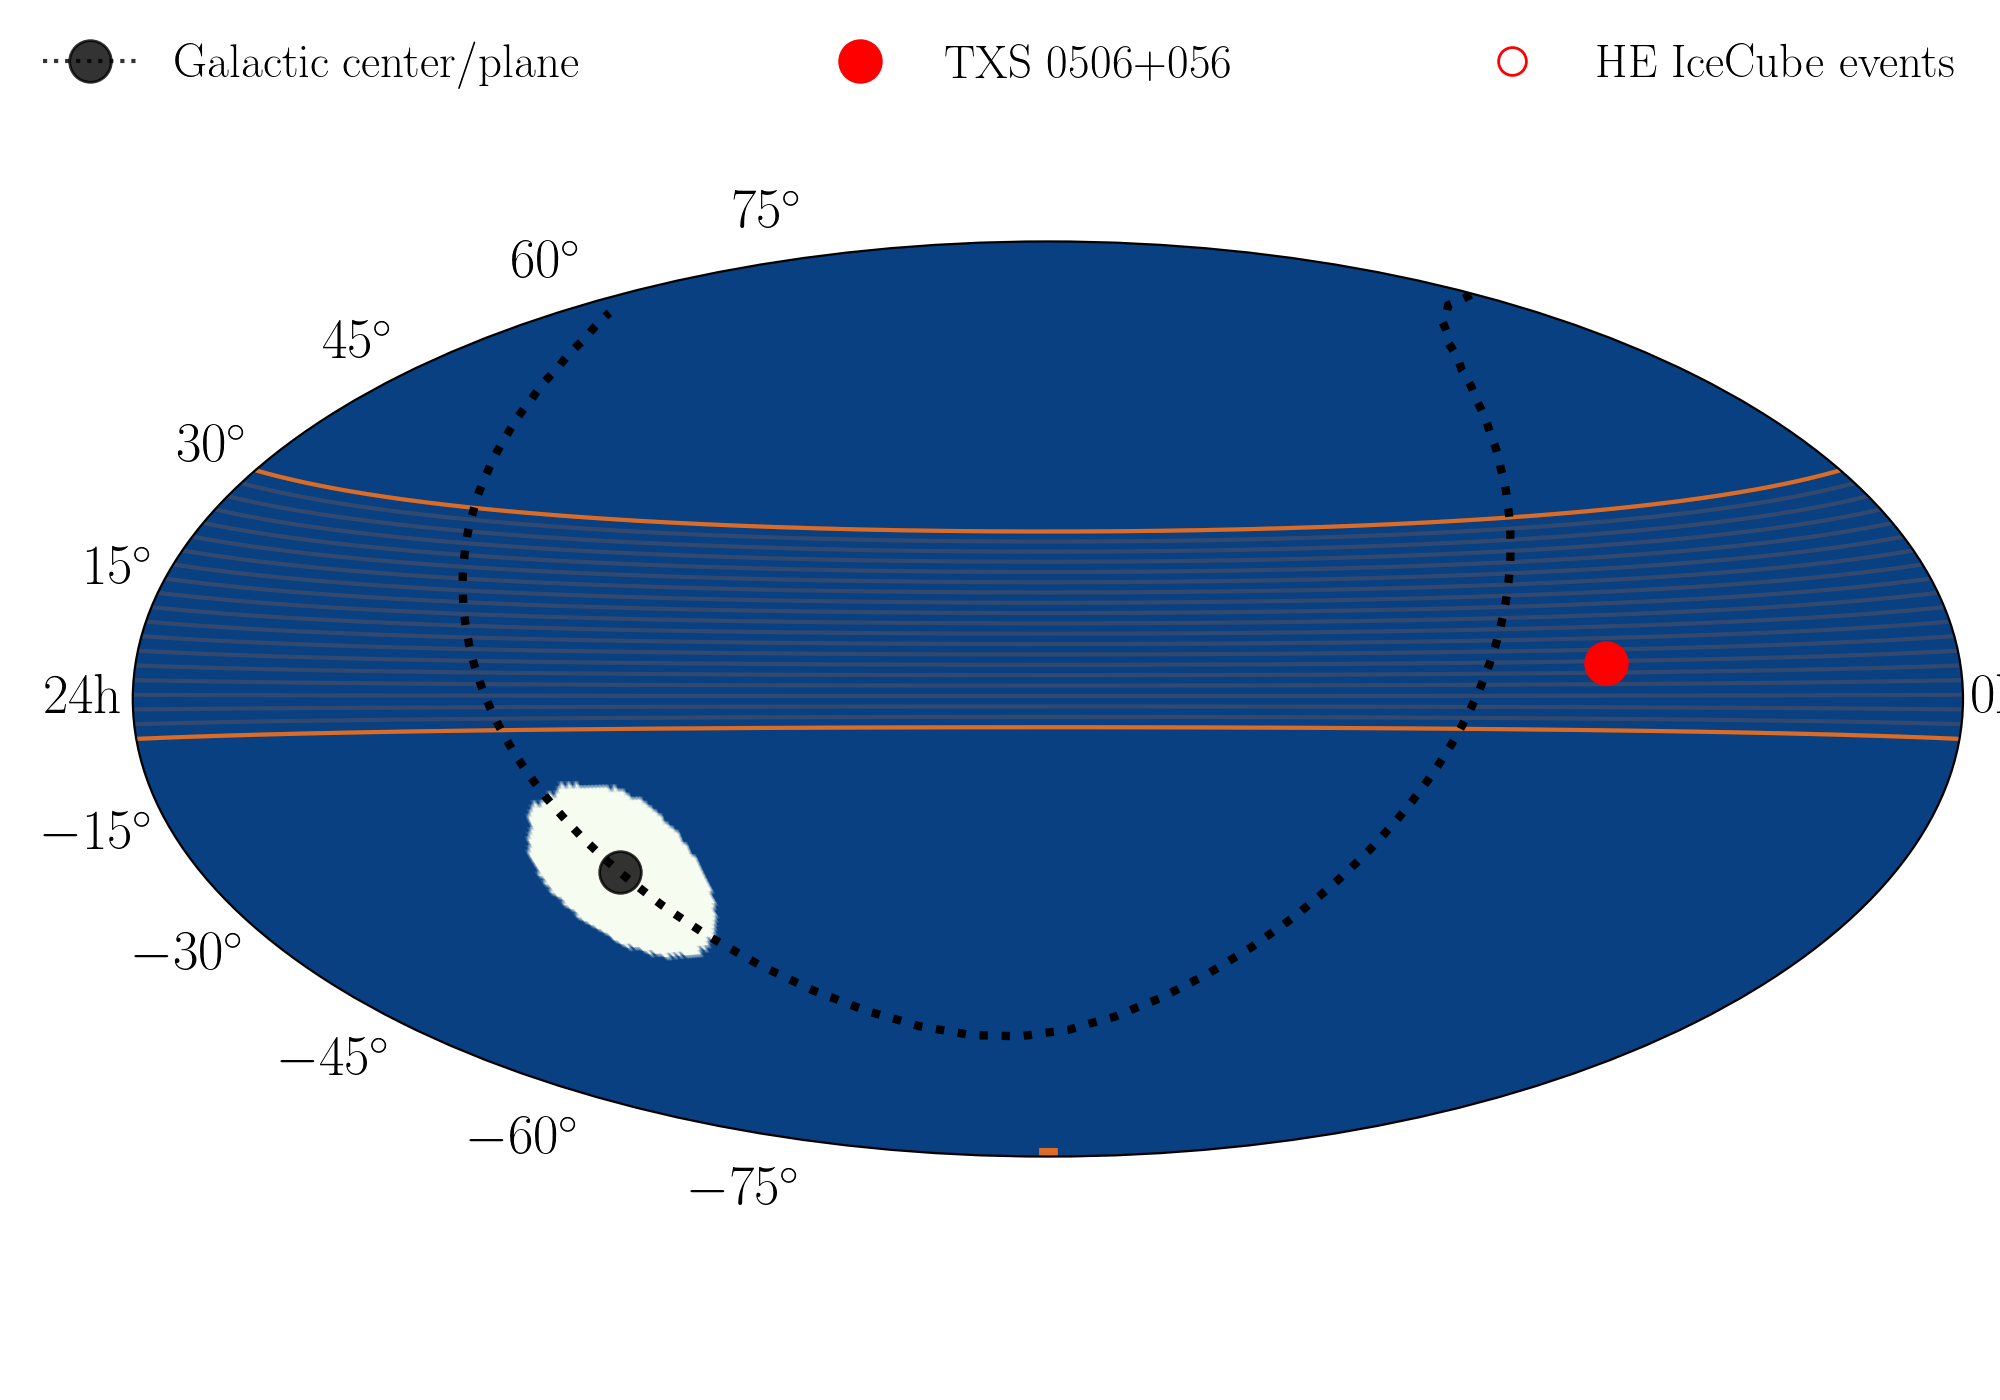

('N pixels:', 838.0, 49152)


In [67]:
fig =  plt.figure(figsize=(10,7.))

ax= fig.add_subplot(111, projection='hammer',
                                       rasterized=True)

#-------------------------------
#plot everything
#-------------------------------


cax=plot_area(new_vals*lt, ax, npix=ngrid,  alpha=1., #vmin=2.e-1, #vmax=1.,
             shading='gouraud', cmap='GnBu_r',norm=LogNorm())

print('N pixels:', np.sum(new_vals), len(new_vals))

#cbar = fig.colorbar(cax,  orientation='horizontal')
#cbar.set_label(r'$N_{\mathrm{bckg}}$ / pixel', 
#               fontsize=fs)
#cbar.ax.tick_params(labelsize=fs)


#---------------------------------------
# show the IceCube lines between -5 and 30 deg
#---------------------------------------
c = '#DC6C25'
num = 10
x = np.linspace(0,2*np.pi, num)
y = np.tile(np.radians(-5.) ,num)

_x,_y =  _trans(x, y)
ind = np.argsort(_x)
ax.plot(_x[ind], _y[ind], color=c)

for y_i in np.linspace(-5, 30,num=20, endpoint=True): 
    y2 = np.tile(y_i ,len(x))
    
    _x2, _y2 = _trans(x, np.radians(y2))
    ind = np.argsort(_x2)
    ax.plot(np.sort(_x2), _y2[ind], color=c, alpha=0.2)

ind = np.argsort(_x2)
ax.plot(_x2[ind], _y2[ind], color=c)

loc1, loc2 = _trans(0, -np.pi/2)
ax.plot(loc1, loc2, marker='s', c=c, linestyle='None')




#-------------------------------
# fix the labels
#-------------------------------

set_ticks(ax, fs=fs)
    

#---------------------------------------
# add the galactic center and plane
#---------------------------------------

add_plane(ax, color='black')

add_txs(ax)



#get all legend entries and add the circle for the HE events
handles, labels = ax.get_legend_handles_labels()
HE_events = Line2D(range(1), range(1), color="red", marker='o',markersize=10, markerfacecolor="None",
              linewidth=0, label='HE IceCube events')

handles.append(HE_events)

fig.legend(handles=handles, fontsize=fs-3, loc='best', mode='expand',
            ncol=3, frameon=False)




fig.tight_layout()

plt.subplots_adjust(top = 0.98)#, bottom=0.2)
fig.savefig('plots/Galactic_Center_Template.png',
               bbox_inches="tight", dpi=200)

--------
# This is the start for the analysis chain for a certain template
-------

# get the background values vs energy


In [26]:
# this is the template that we want to use
t_mask = mask_template_gc
template = 'galactic center'


num = 5000#5000
x = np.linspace(0,2*np.pi, num)
y = np.linspace(-np.pi/2,np.pi/2 , 200)  # 500

Background_values = dict()
Background_values_prompt = dict()
Signal_values = dict()
    
for exp in ['icecube', 'plenum']:


    Bckg_vals = np.zeros_like(e_mids, dtype=float)
    Bckg_vals_pr = np.zeros_like(e_mids, dtype=float)

    Sig_vals = np.zeros_like(e_mids, dtype=float)

    ntot_numu = Res_numu[exp]
    ntot_numu_prompt = Res_numu_prompt[exp]

    ntot_mu = Res_mu[exp]
    ntot_mu_prompt = Res_mu_prompt[exp]

    ntot_sig = ResSig[exp]


    

    for k, i in enumerate(e_mids):    
    
        # spline fit all distributions to get more accurate results
        max_val = np.max(ntot_numu[k])
        tck = splrep(get_mids(sd_bins), ntot_numu[k]/max_val , s=1.e-2)

        max_val_numu_pr = np.max(ntot_numu_prompt[k])
        tck_numu_pr = splrep(get_mids(sd_bins), ntot_numu_prompt[k]/max_val_numu_pr , s=1.e-2)

        max_val_mu = np.max(ntot_mu[k])
        tck_mu = splrep(get_mids(sd_bins), ntot_mu[k]/max_val_mu , s=1.e-2)

        max_val_mu_pr = np.max(ntot_mu_prompt[k])
        tck_mu_pr = splrep(get_mids(sd_bins), ntot_mu_prompt[k]/max_val_mu_pr , s=1.e-2)

        max_val_sig = np.max(ntot_sig[k])
        tck_sig = splrep(get_mids(sd_bins), ntot_sig[k]/max_val_sig , s=1.e-2)

        bckg_vals2 = np.ones(npix)
        bckg_vals_pr = np.ones(npix)
        sig_vals2 = np.ones(npix)
        for dec_i in y:

            #get the pixels
            p = hp.ang2pix(NSIDE, dec_i+np.pi/2, x)
            #fill them 
            # psize account for the pixel size that was chosen
            # hence bckg_vals describe the bckg expectation N from atm numu 
            # per second


            if (dec_i < np.deg2rad(-5.))&(exp=='icecube'):
                bckg_vals2[p] = (splev(np.sin(dec_i), tck)*max_val * psize
                                 + splev(np.sin(dec_i), tck_mu)*max_val_mu * psize)

                bckg_vals_pr[p] = (splev(np.sin(dec_i), tck_numu_pr)*max_val_numu_pr * psize
                                   + splev(np.sin(dec_i), tck_mu_pr)*max_val_mu_pr * psize)
            else:    
                bckg_vals2[p] = splev(np.sin(dec_i), tck)*max_val * psize
                bckg_vals_pr[p] = splev(np.sin(dec_i), tck_numu_pr)*max_val_numu_pr * psize


            sig_vals2[p] = splev(np.sin(dec_i), tck_sig)*max_val_sig * psize


        

        bckg_vals2[~t_mask] = 0
        Bckg_vals[k] = np.sum(bckg_vals2*lt)

        bckg_vals_pr[~t_mask] = 0
        Bckg_vals_pr[k] = np.sum(bckg_vals_pr*lt)

        sig_vals2[~t_mask] = 0
        Sig_vals[k] = np.sum(sig_vals2*lt)

    
    Background_values[exp] = Bckg_vals
    Background_values_prompt[exp] = Bckg_vals_pr
    Signal_values[exp] = Sig_vals
    

<IPython.core.display.Javascript object>


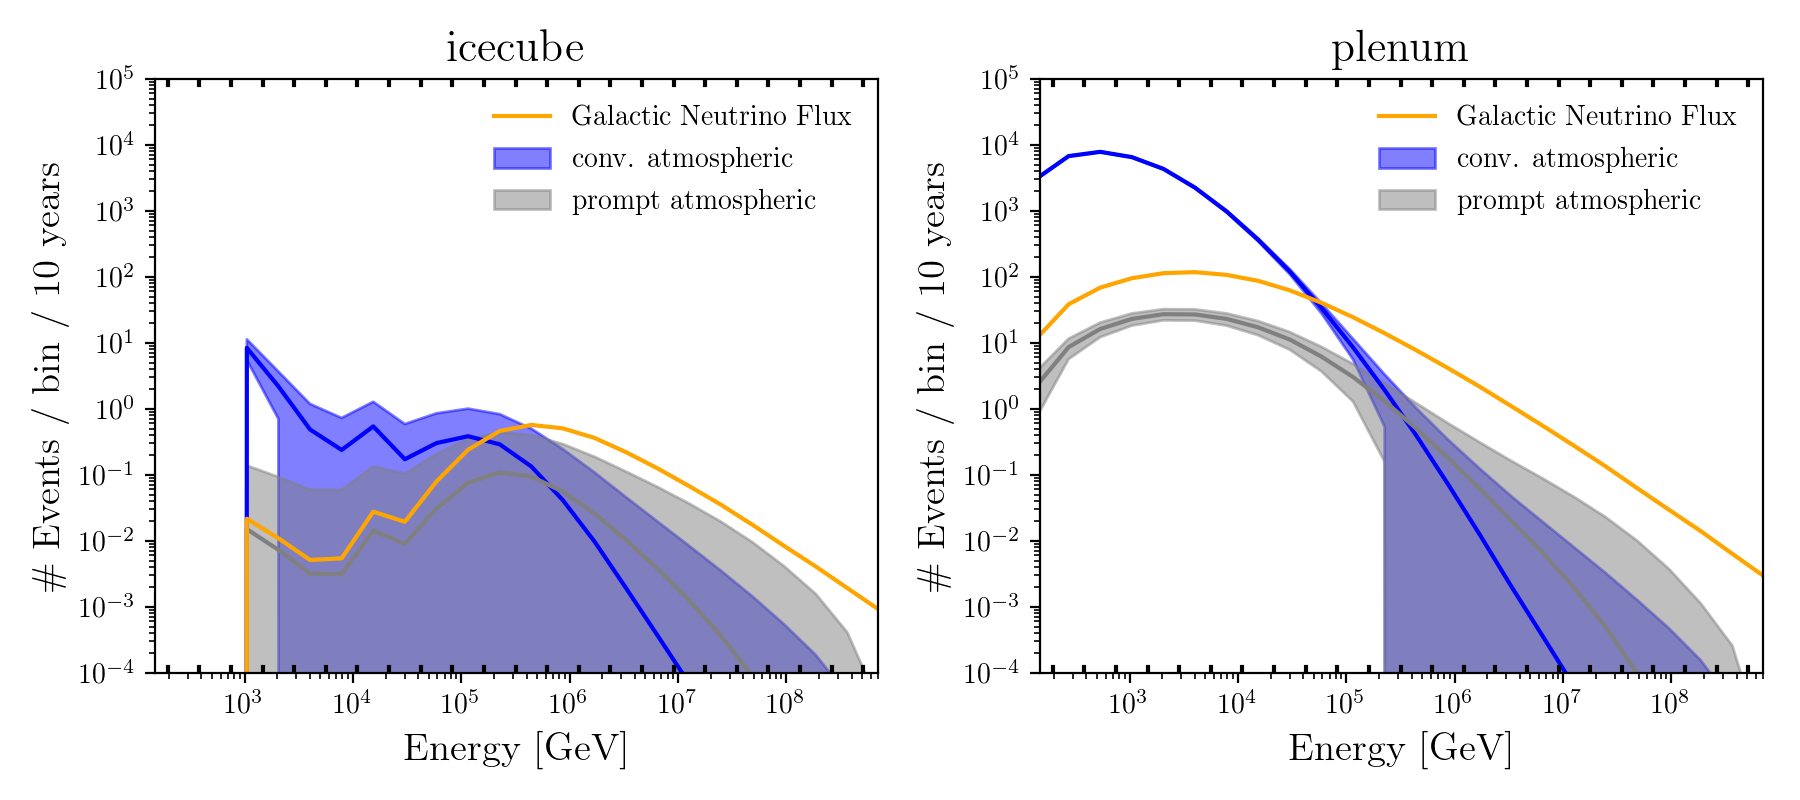

In [56]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

for k, exp in enumerate(['icecube', 'plenum']):

    ax = axes[k]
    ax.set_title(exp, fontsize=16)
    Bckg_vals = Background_values[exp]
    Bckg_vals_pr = Background_values_prompt[exp]
    Sig_vals = Signal_values[exp]
    
    Bckg_vals[Bckg_vals<=0] = 0
    yerr=np.sqrt(Bckg_vals)
    ax.plot(e_mids, Bckg_vals, color='blue')
    ax.fill_between(e_mids, Bckg_vals-yerr, Bckg_vals+yerr, alpha=0.5, color='blue',
                   label = r'conv. atmospheric')

    Bckg_vals_pr[Bckg_vals_pr<=0] = 0
    yerr=np.sqrt(Bckg_vals_pr)
    ax.plot(e_mids, Bckg_vals_pr, color='grey')
    ax.fill_between(e_mids, Bckg_vals_pr-yerr, Bckg_vals_pr+yerr, alpha=0.5, color='grey',
                   label = r'prompt atmospheric')


    Sig_vals[Sig_vals<=0] = 0
    ax.plot(e_mids, Sig_vals, color='orange', label='Galactic Neutrino Flux')


    # indicate the binning in energy
    for ei in e_bins:
        ax.axvline(ei, ymin=0, ymax=0.01, color='black')
        ax.axvline(ei, ymin=0.99, ymax=1, color='black')


    ax.set_xlim(1.5e2,0.7e9)
    ax.set_ylim(1e-4,1.e5)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel('Energy [GeV]', fontsize=14)
    ax.set_ylabel(r'\# Events / bin / 10 years', fontsize=14)
    ax.legend(loc='upper right', frameon=False)

fig.tight_layout()
fig.savefig('plots/expected_ev_number_galactic_center.pdf'.format(exp))

# in order fo fit the spectral index and flux normalisation we need a function that relates the expected bin entries to the physical parameters 

here this is $\lambda_i = f(i|\phi_0, \gamma)$

In [28]:
def conv_phi100_to_phi0(phi100, gamma):
    return 10**(5.*gamma) * phi100
    

In [29]:
phi100s = 10**np.linspace(-21,-17, 10)
gammas = np.arange(1.5,4.1,0.5)

# function relating physical parameters to expected bin counts
# (dec, energy, phi0, gamma)
F = dict()

for exp in ['icecube', 'plenum']:

    fexp  = np.zeros((n_sd, n_e, len(phi100s), len(gammas)), dtype=float)
    effA = copy(results['effA_'+exp].reshape((n_sd, n_e)))

    for i, sd_i in enumerate(get_mids(sd_bins)):
    
        h_aeff = effA[i]
        for k, phi100i in enumerate(phi100s):
            for l, gamma_l in enumerate(gammas):
                phi0i = conv_phi100_to_phi0(phi100i, gamma_l)
                fexp[i,:,k,l] = [phi0i * int_powerlaw(gamma_l, e_bins[j], e_bins[j+1]) * h_aeff[j] 
                                for j,ej in enumerate(e_mids)] 

    F[exp] = fexp
    print('{0} done!'.format(exp))
    

icecube done!
plenum done!


<IPython.core.display.Javascript object>


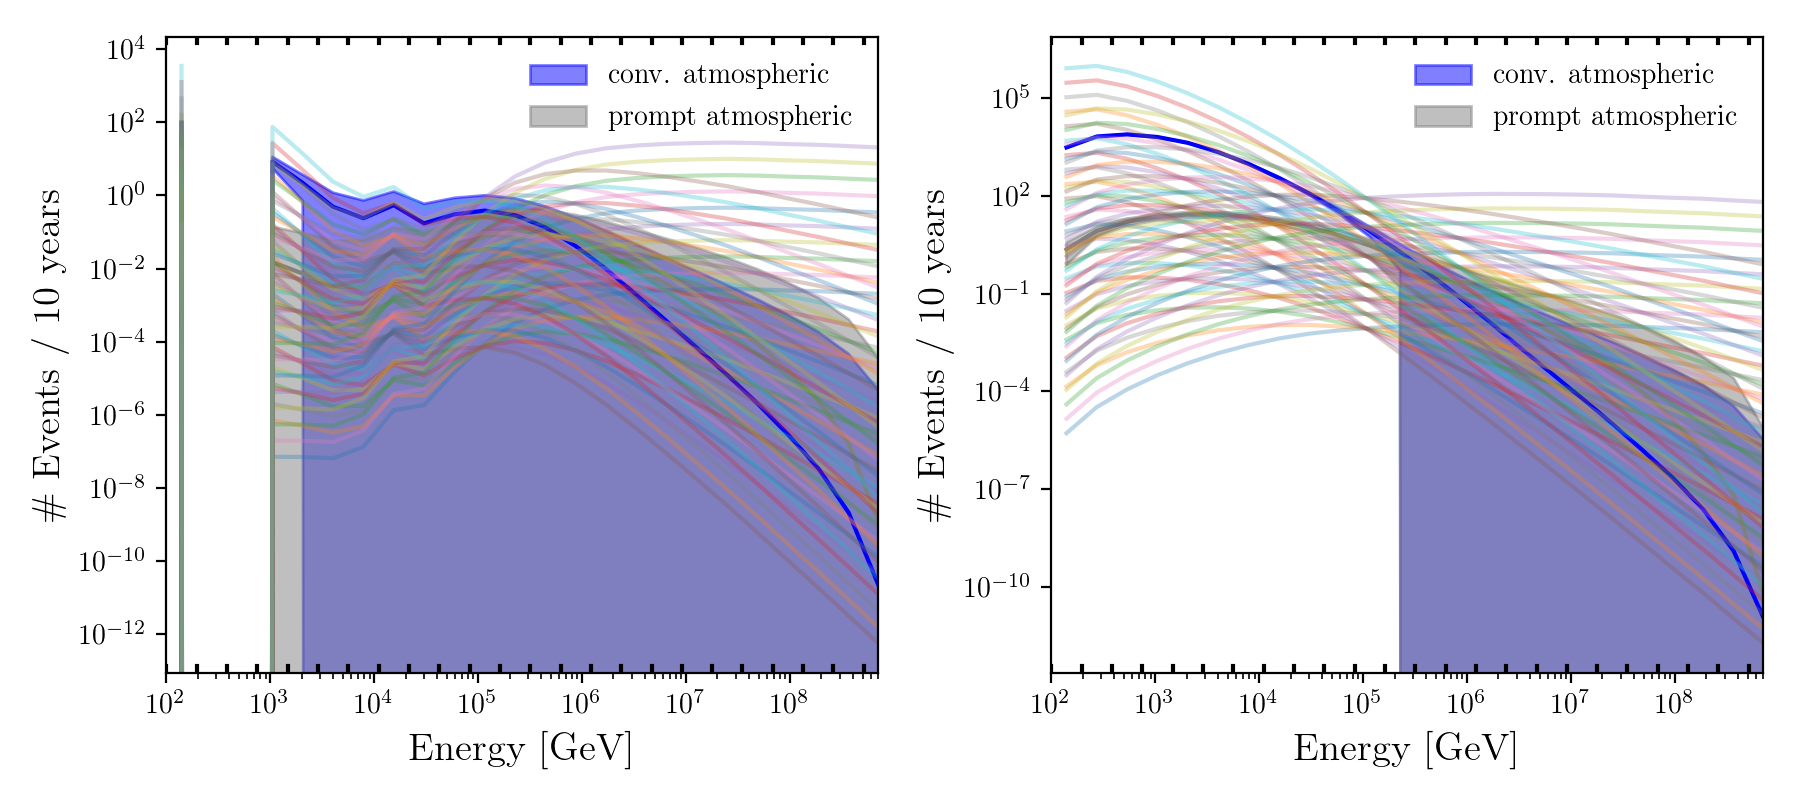

1 out of 10 normalisations done!
2 out of 10 normalisations done!
3 out of 10 normalisations done!
4 out of 10 normalisations done!
5 out of 10 normalisations done!
6 out of 10 normalisations done!
7 out of 10 normalisations done!
8 out of 10 normalisations done!
9 out of 10 normalisations done!
10 out of 10 normalisations done!
1 out of 10 normalisations done!
2 out of 10 normalisations done!
3 out of 10 normalisations done!
4 out of 10 normalisations done!
5 out of 10 normalisations done!
6 out of 10 normalisations done!
7 out of 10 normalisations done!
8 out of 10 normalisations done!
9 out of 10 normalisations done!
10 out of 10 normalisations done!


In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

F_TEMPLATE = dict()

for k, exp in enumerate(['icecube', 'plenum']):

    ax = axes[k]
    Bckg_vals = Background_values[exp]
    Bckg_vals_pr = Background_values_prompt[exp]
    Sig_vals = Signal_values[exp]

    Bckg_vals[Bckg_vals<=0] = 0
    yerr=np.sqrt(Bckg_vals)
    ax.plot(e_mids, Bckg_vals, color='blue')
    ax.fill_between(e_mids, Bckg_vals-yerr, Bckg_vals+yerr, alpha=0.5, color='blue',
                   label = r'conv. atmospheric')

    Bckg_vals_pr[Bckg_vals_pr<=0] = 0
    yerr=np.sqrt(Bckg_vals_pr)
    ax.plot(e_mids, Bckg_vals_pr, color='grey')
    ax.fill_between(e_mids, Bckg_vals_pr-yerr, Bckg_vals_pr+yerr, alpha=0.5, color='grey',
                   label = r'prompt atmospheric')

    # add all possible outcomes to the final plot jus to see if the calculation of F makes sense

    f = F[exp]
    cs = ['orange','red','pink']

    F_template = np.zeros(( len(phi100s), len(gammas), n_e), dtype=float)

    for l, phi100l in enumerate(phi100s):

        for m, gamma_m in enumerate(gammas):
            sig_final = np.zeros_like(e_mids, dtype=float)
            for k, i in enumerate(e_mids):

                max_val_sig = np.max(f[:,k,l,m])
                tck_sig = splrep(get_mids(sd_bins), f[:,k,l,m]/max_val_sig , s=1.e-2)

                sig_valsi = np.ones(npix)
                for dec_i in y:
                    #get the pixels
                    p = hp.ang2pix(NSIDE, dec_i+np.pi/2, x)
                    sig_valsi[p] = splev(np.sin(dec_i), tck_sig)*max_val_sig * psize


                sig_valsi[~t_mask] = 0
                sig_final[k] = np.sum(sig_valsi*lt)

            sig_final[sig_final<=0] = 0
            F_template[l,m,:] = sig_final

            ax.plot(e_mids, sig_final,  alpha=0.3) # color=cs[m] ,
        print('{0} out of {1} normalisations done!'.format(l+1, len(phi100s)))

    F_TEMPLATE[exp] = F_template
    # indicate the binning in energy
    for ei in e_bins:
        ax.axvline(ei, ymin=0, ymax=0.01, color='black')
        ax.axvline(ei, ymin=0.99, ymax=1, color='black')


    ax.set_xlim(1e2,0.7e9)
    #ax.set_ylim(1e-4,1.e5)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel('Energy [GeV]', fontsize=14)
    ax.set_ylabel(r'\# Events / 10 years', fontsize=14)
    ax.legend(loc='upper right', frameon=False)

fig.tight_layout()

# Try to spline fit the functions 

<IPython.core.display.Javascript object>


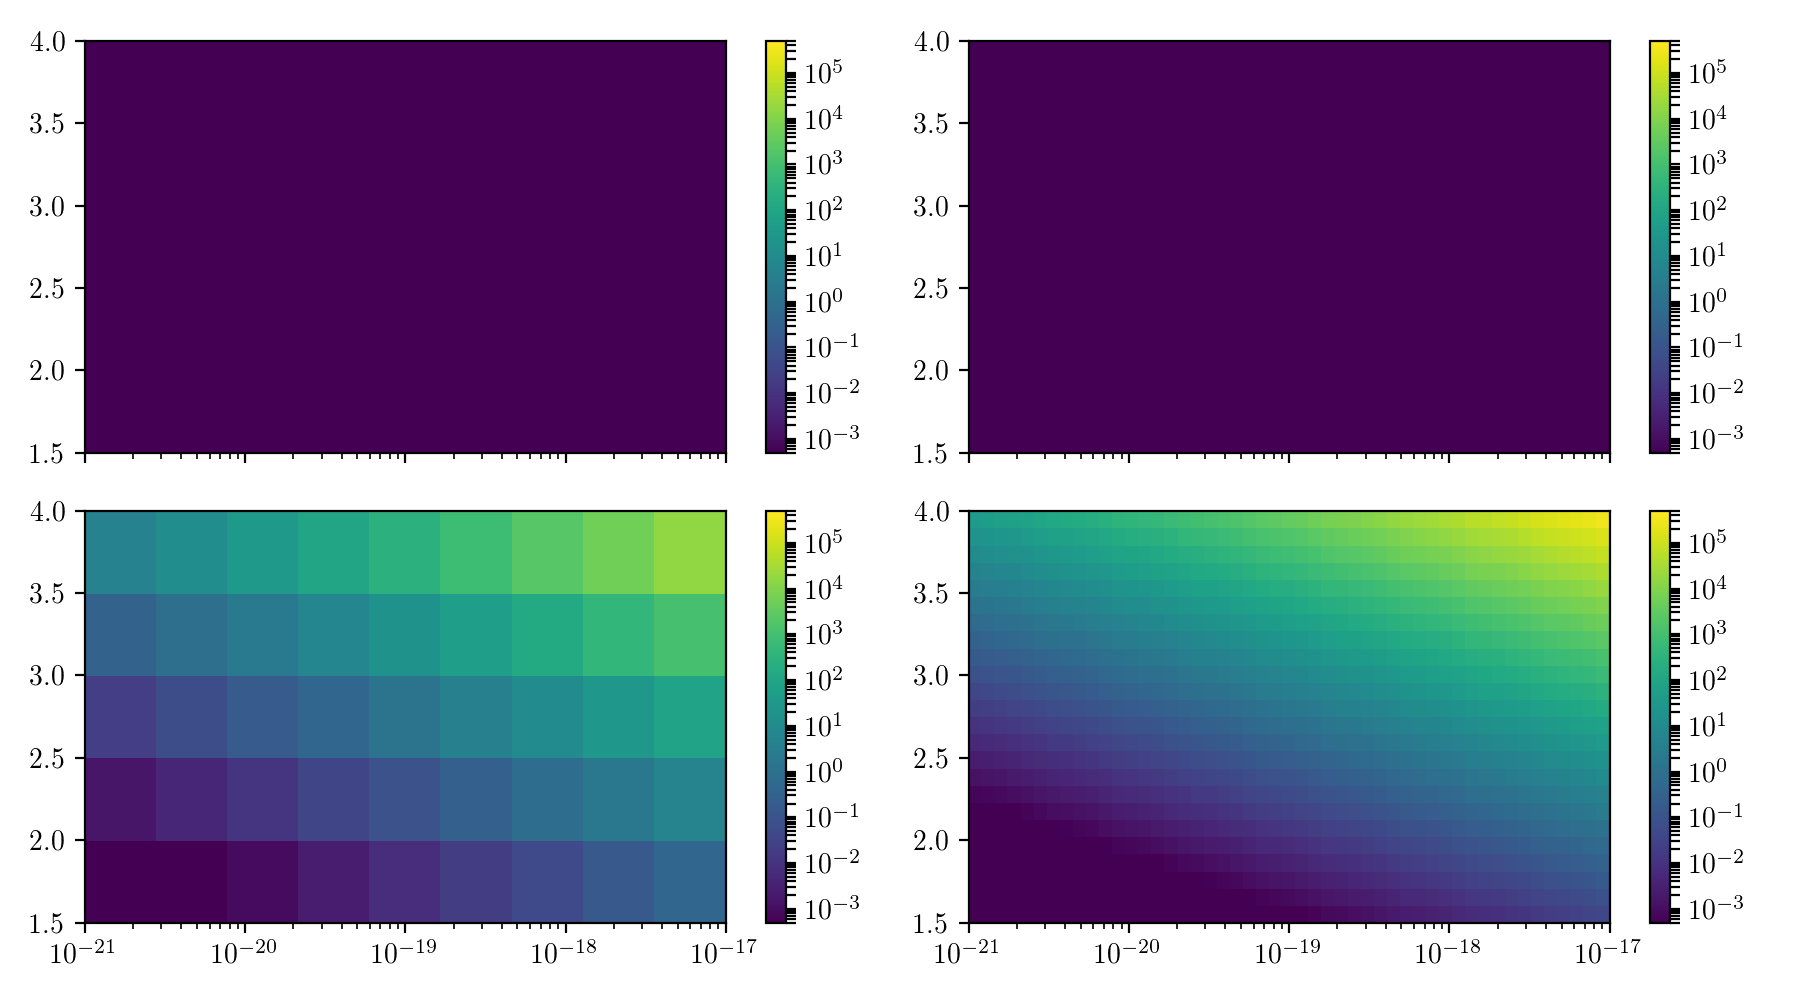

2


In [31]:
import scipy
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9,5), sharex=True)

Splines = dict()

for k, exp in enumerate(['icecube', 'plenum']):
    
    F_template = copy(F_TEMPLATE[exp])
    F_template[F_template==0] = 1e-15
    
    if template == 'galactic center' and exp=='icecube':
        ind = np.array(np.argwhere(e_mids<1e3).flatten())[-1]
        print(ind)
        F_template[...,:ind] = 1e-15
    
    binmids = (phi100s, gammas, e_mids)
    spline = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(F_template),
                    method="linear",
                    #bounds_error=False,
                    #fill_value=0.
                    )

    Splines[exp] = spline
    ax = axes[k,0]
    p = ax.pcolormesh(phi100s, gammas, F_template[...,2].T, norm=LogNorm(), 
                      vmax=5e5,vmin=5e-4)
    cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')

    ax = axes[k,1]
    _phis = 10**np.linspace(np.log10(np.min(phi100s)), np.log10(np.max(phi100s)), 50 )

    _gs = np.linspace(np.min(gammas), np.max(gammas), 25)
    xx, yy = np.meshgrid(_phis, _gs, indexing='ij')
    spline_res = np.exp(spline((xx,yy,e_mids[0])))


    p = ax.pcolormesh(_phis, _gs, spline_res.T, norm=LogNorm(),  vmax=5e5,vmin=5e-4)
    cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')

fig.tight_layout()

---
# define a test statistic function based on poisson statistics 
---

In [32]:
def conv_func(log10_phi100, gamma, spline):
    _phi100 = np.atleast_1d(10**log10_phi100)
    gamma = np.atleast_1d(gamma)
    return np.exp(spline((_phi100, gamma, e_mids[:,np.newaxis]))).T

In [33]:
rand = np.random.RandomState(0)
def generate_bckg_data(lambda_b, n_trials):
    out = rand.poisson(lambda_b, size=(n_trials, len(lambda_b)))
    return out
    
def generate_signal_data(log10_phi100, gamma, n_trials, spline):
    lambda_s = conv_func(log10_phi100, gamma, spline)[0]
    out = rand.poisson(lambda_s, size=(n_trials, len(lambda_s)))
    return out

In [34]:
def LambdaTS(log10_phi100, gamma, data, lambda_b, spline):
    r'''
    phi100: flux normalisation at 100TeV of the singal
    gamma: spectral index of the singal
    data: observed number of events in each energy bin
    lambda_b: expected number of background events in each bin
    '''
    
    lambda_s = conv_func(log10_phi100, gamma, spline)
    r = lambda_s / lambda_b #background expectation should not be 0
    
    _mask = (np.ones_like(lambda_s)*lambda_b) == 0
    r[_mask] = 0
    res = 2 * np.sum(np.log(1+r) * data[:,np.newaxis] - lambda_s, axis=2)
    return res

# Do a little llh scan for one data trial
we have to calculate trials in bunches of 1e4 otherwise the matrix gets too big

In [35]:
import time

N_trials = int(1e4)
n_trials = int(1e4)


MAX_VALS = dict()
for _,exp in enumerate(['icecube', 'plenum']):

    lambda_b = copy(Background_values[exp])
    if template == 'galactic center' and exp=='icecube':
        mask = e_mids<1e3
        lambda_b[mask] = 0
    
    
    spline = Splines[exp]
    Max_vals = np.array([])
    start = time.clock()
    for i in range(N_trials/ n_trials):

        di = generate_bckg_data(lambda_b=lambda_b, n_trials=n_trials)

        _phis = 10**np.linspace(np.log10(np.min(phi100s)), np.log10(np.max(phi100s)), 50 )
        _gs = np.linspace(np.min(gammas), np.max(gammas), 30)


        xx, yy = np.meshgrid(_phis, _gs, indexing='ij')

        llh_scan = np.zeros_like(xx.flatten(), dtype=float)


        llh_scan = LambdaTS(np.log10(xx.flatten()), yy.flatten(), di, lambda_b , spline)


        llh_scan = llh_scan.reshape((n_trials,)+xx.shape)

        max_vals = np.max(llh_scan, axis=(1,2))
        max_vals[max_vals<0] = 0

        Max_vals = np.append(Max_vals,max_vals)
        print('{0} trials done ({1:.1f}%)!'.format((i+1)*n_trials,100*((i+1)*n_trials)/ float(N_trials) ))

    MAX_VALS[exp] = Max_vals    
    
    stop = time.clock()
    mins, secs = divmod(stop-start,60)
    hours,mins = divmod(mins,60)
    print("LLH scan finished after {0:3d}h {1:2d}' {2:4.2f}''".format(int(hours),int(mins),secs))

10000 trials done (100.0%)!
LLH scan finished after   0h  0' 7.44''
10000 trials done (100.0%)!
LLH scan finished after   0h  0' 4.57''


# Show some examplary llh scans

<IPython.core.display.Javascript object>


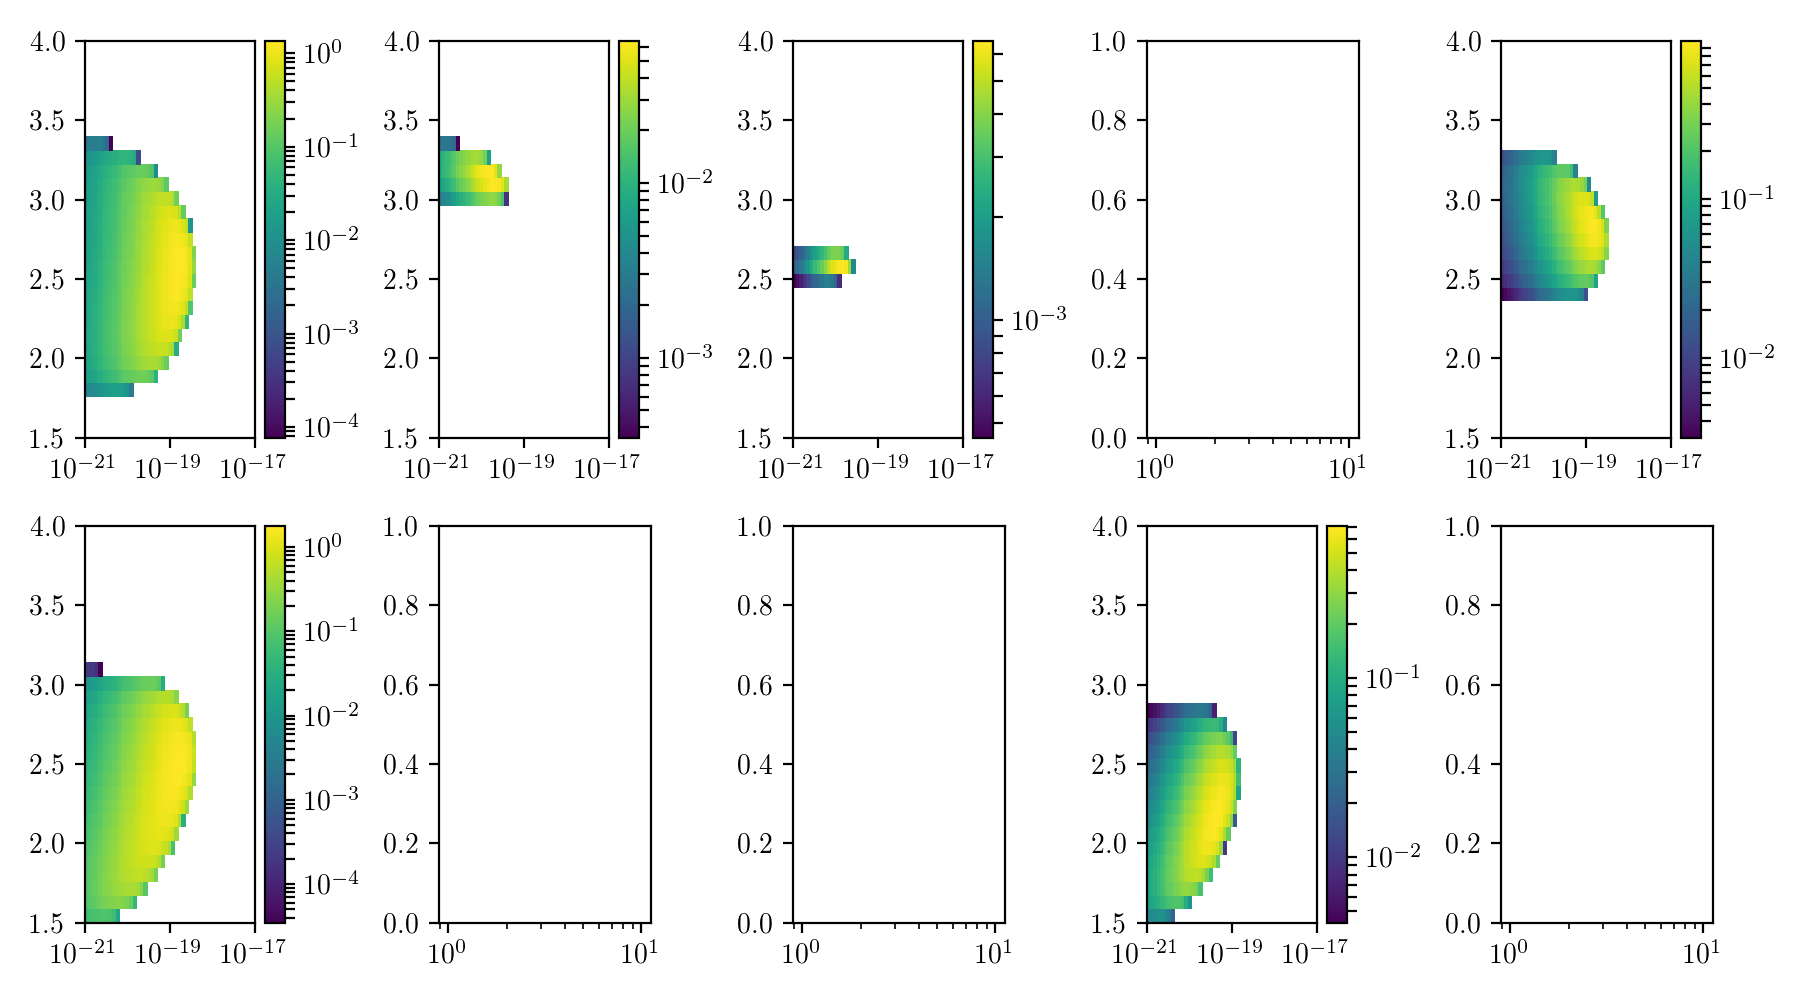

In [36]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(9,5))

for i, llh_scani in enumerate(llh_scan[:10]):
    ax = axes[i//5, i%5]
    
    if np.max(llh_scani) >0:
        p = ax.pcolormesh(_phis, _gs, llh_scani.T, norm=LogNorm(), 
                  )
        cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')
    
fig.tight_layout()

# Show the background TS distribution 

In [37]:
sys.path.append('/Users/mhuber/skylab/SVN_stable_v2-03/')
from _svnskylab.utils import FitDeltaChi2, delta_chi2

0.3187


<IPython.core.display.Javascript object>


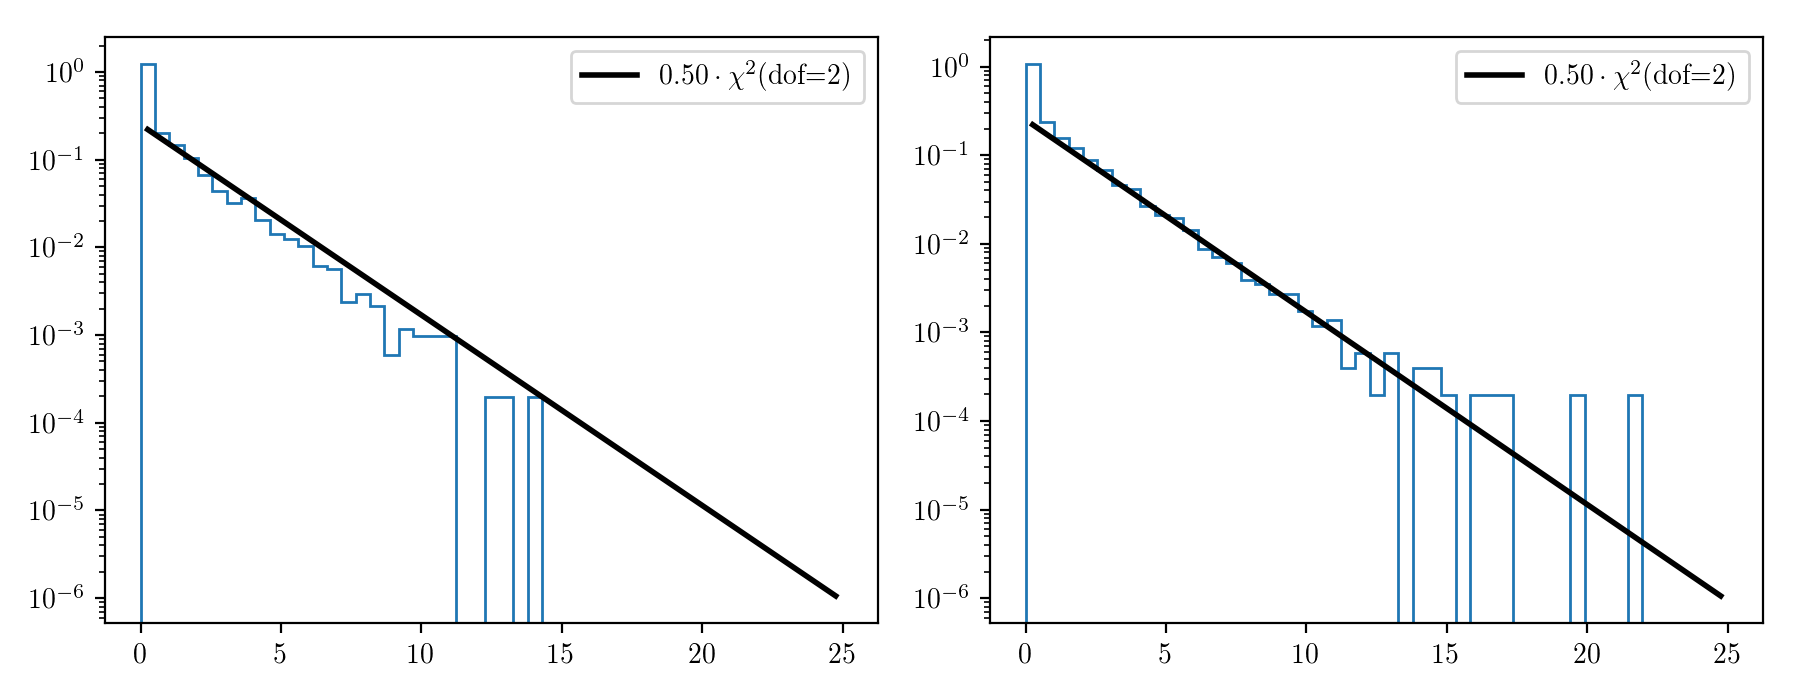

[2.48219446 0.         0.21986428 ... 1.62188609 0.         0.14442317]
[1.3523189  0.06486542 0.00652954 ... 0.         0.92058678 0.37872173]


In [38]:
print(np.sum(Max_vals<=0.01)/ float(len(Max_vals)))

fig, axes = plt.subplots(ncols=2, figsize=(9,3.5))

bins = np.linspace(0,25,50)

for k, exp in enumerate(['icecube', 'plenum']):

    ax = axes[k]
    ax.set_title(exp, fontsize=16)
    Max_vals = MAX_VALS[exp]
    print(Max_vals)
    ax.hist(Max_vals, bins=bins, histtype='step', density=True)

    xvals = get_mids(bins)
    fit_func = delta_chi2(eta=0.5, df=2.)
    fit_vals = fit_func.pdf(xvals)
    fit_vals[:] /= (np.sum(fit_vals) /(fit_func.eta))
    ax.plot(xvals, fit_vals / np.diff(xvals)[0] , color='black', lw=2., 
                label=r'$0.50\cdot \chi^2$(dof=2)')

    ax.legend()
    ax.set_yscale('log')
    
fig.tight_layout()

# Now calculate the 5 sigma threshold and check which fluxes generate a 5sigma in at least 50% of the cases

In [39]:
ts_5sigma = 15. # random guess for now, don't want to think about this now
n_trials =  int(5e2)

phi_lims = 10**np.linspace(np.log10(np.min(phi100s)), np.log10(np.max(phi100s)), 25 )
g_lims = np.linspace(np.min(gammas), np.max(gammas), 10)


TS_Results = dict()
for k, exp in enumerate(['icecube', 'plenum']):

    spline = Splines[exp]
    lambda_b = Background_values[exp]
    if template == 'galactic center' and exp=='icecube':
        mask = e_mids<1e3
        lambda_b[mask] = 0
    
    
    ts_res = np.zeros((len(phi_lims)*len(g_lims), n_trials))
    XX, YY = np.meshgrid(phi_lims, g_lims, indexing='ij')
    
    n=0
    for i, (pi,gj) in enumerate(zip(XX.flatten(), YY.flatten())):

        d_bckg = generate_bckg_data(lambda_b=lambda_b, n_trials=n_trials)
        d_sig = generate_signal_data(np.log10(pi), gj, n_trials=n_trials, spline=spline)
        d_tot = d_bckg+d_sig


        _phis = 10**np.linspace(np.log10(np.min(phi100s)), np.log10(np.max(phi100s)), 50 )
        _gs = np.linspace(np.min(gammas), np.max(gammas), 30)


        xx, yy = np.meshgrid(_phis, _gs, indexing='ij')

        llh_scan = np.zeros_like(xx.flatten(), dtype=float)


        llh_scan = LambdaTS(np.log10(xx.flatten()), yy.flatten(), d_tot, lambda_b ,spline)


        llh_scan = llh_scan.reshape((n_trials,)+xx.shape)

        max_vals = np.max(llh_scan, axis=(1,2))
        max_vals[max_vals<0] = 0

        ts_res[i] = max_vals

        if (i % (ts_res.shape[0]//10) ==0):
            
            print('{0}% done!'.format((n+1)*10))
            n+=1
    TS_Results[exp] = ts_res
        #print('Trials done for phi: {0:.2e} and gamma: {1:.1f}!'.format(pi, gj))



10% done!
20% done!
30% done!
40% done!
50% done!
60% done!
70% done!
80% done!
90% done!
100% done!
10% done!
20% done!
30% done!
40% done!
50% done!
60% done!
70% done!
80% done!
90% done!
100% done!


# Now show the fractions in a 2d plot 

<IPython.core.display.Javascript object>


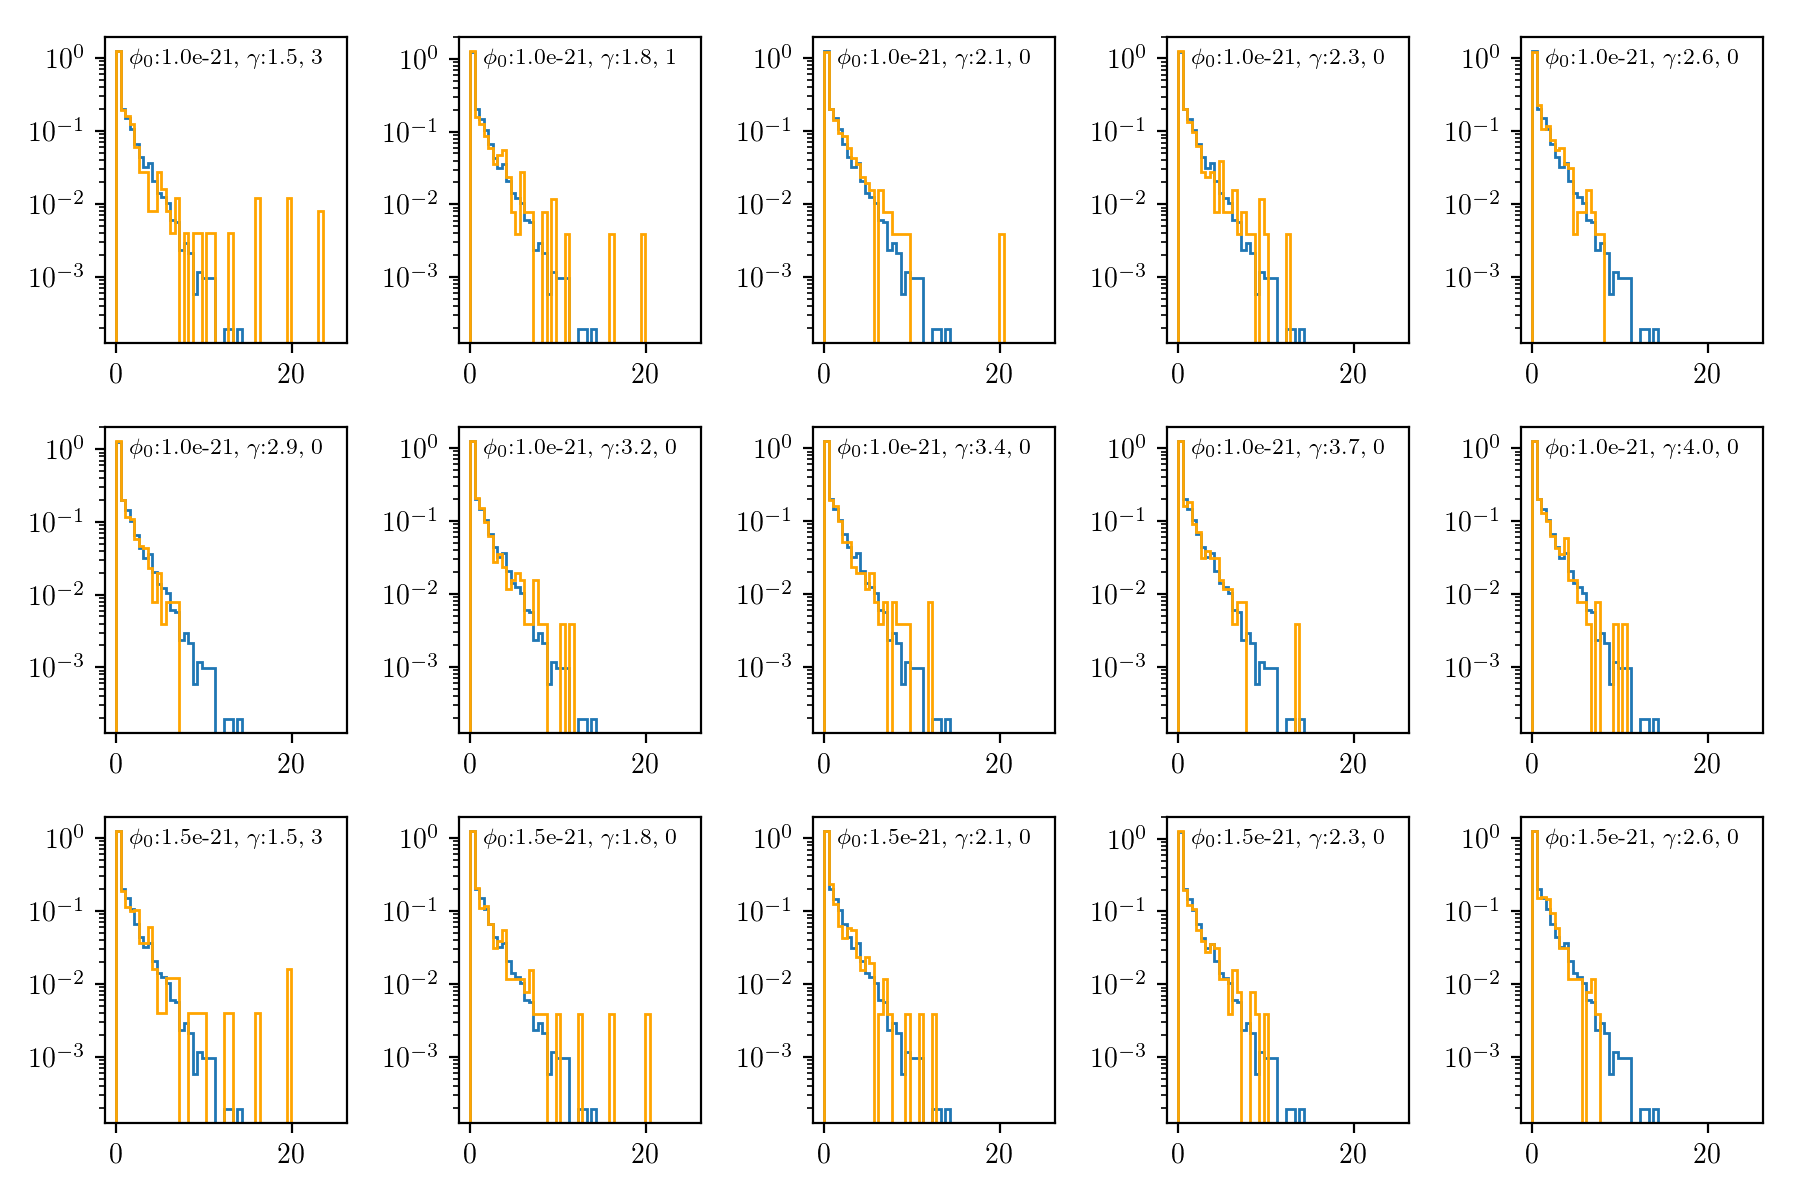

<IPython.core.display.Javascript object>


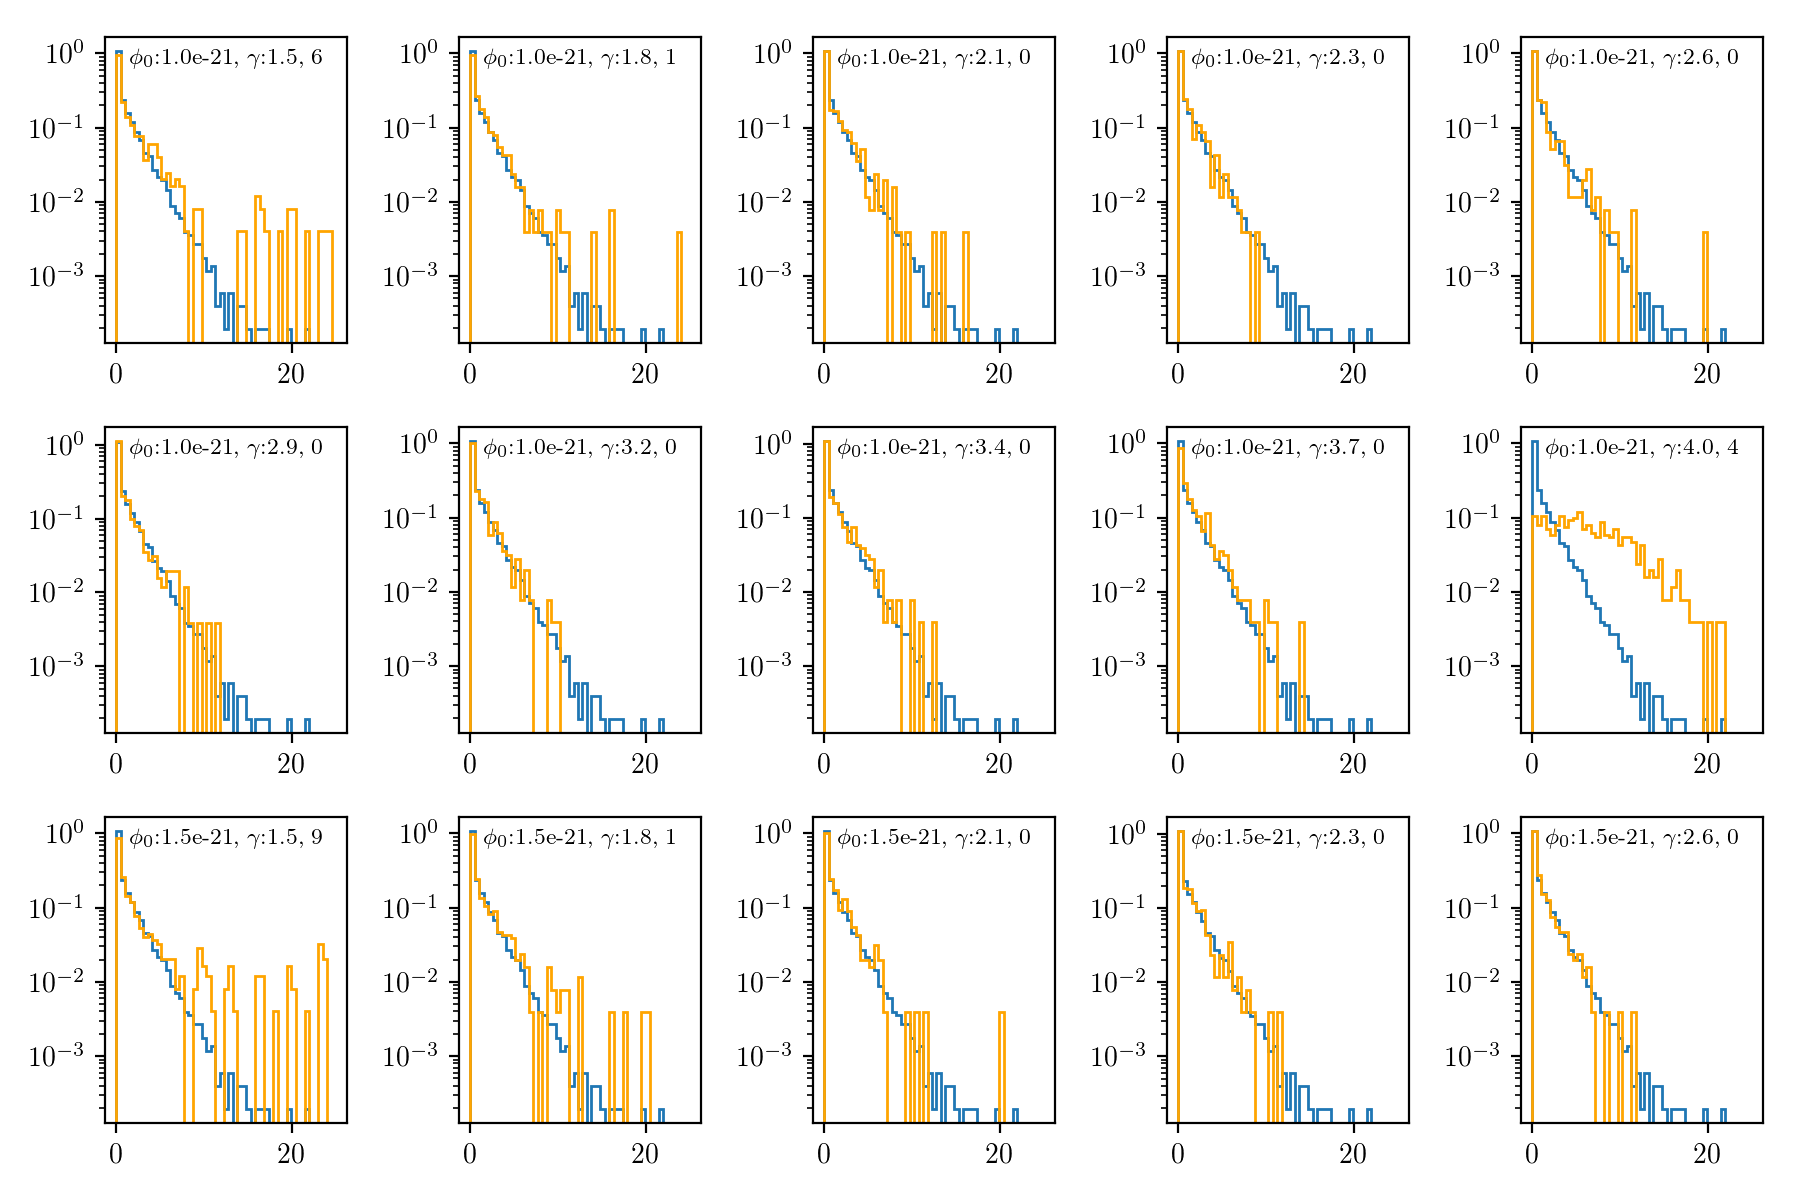

In [41]:
Fractions = dict()

for k, exp in enumerate(['icecube', 'plenum']):
    
    fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(9,6))
    Fracs = np.zeros(ts_res.shape[0], dtype=float)
    Max_vals = MAX_VALS[exp]
    
    ts_res = TS_Results[exp]
    for i, max_vali in enumerate(ts_res):
        # calculate the fraction of trials with ts > ts_5sigma
        fraction = np.sum(max_vali >= ts_5sigma) / float(n_trials)
        Fracs[i] = fraction
        if i >= 15:
            
            continue
        ax = axes[i//5, i%5]


        bins = np.linspace(0,25,50)
        ax.hist(Max_vals, bins=bins, histtype='step', density=True)
        ax.hist(max_vali, bins=bins, histtype='step', density=True, color='orange')


        ax.text(0.1,0.9, r'$\phi_0$:{1:.1e}, $\gamma$:{2:.1f}, {0:.0f}%'.format(100*fraction, XX.flatten()[i],
                                                                         YY.flatten()[i]), fontsize=8 ,
                     transform = ax.transAxes)

        ax.set_yscale('log')

    Fracs = Fracs.reshape(XX.shape)
    Fractions[exp] = Fracs
    fig.tight_layout()
    
    

<IPython.core.display.Javascript object>


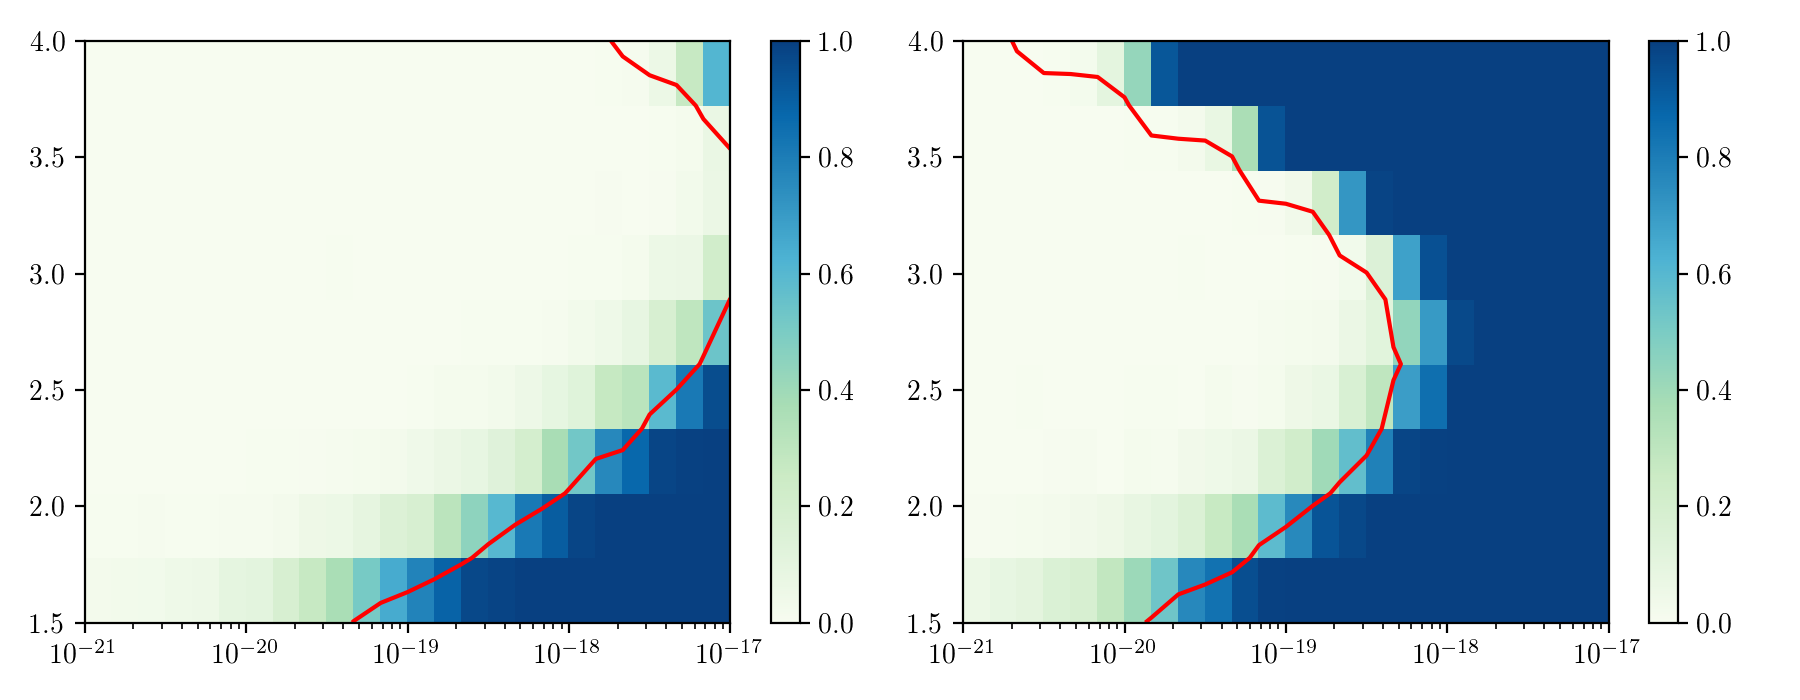

In [42]:
fig, axes = plt.subplots(ncols=2, figsize=(9,3.5))

for k, exp in enumerate(['icecube', 'plenum']):
    ax=axes[k]
    Fracs = Fractions[exp]
    p = ax.pcolormesh(phi_lims, 
                      g_lims, 
                      Fracs.T, 
                      vmin=0, vmax=1, cmap='GnBu'
              )

    ax.contour(phi_lims, g_lims, Fracs.T, levels=[0.5], colors=['red'])
    
    cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')

fig.tight_layout()

<IPython.core.display.Javascript object>


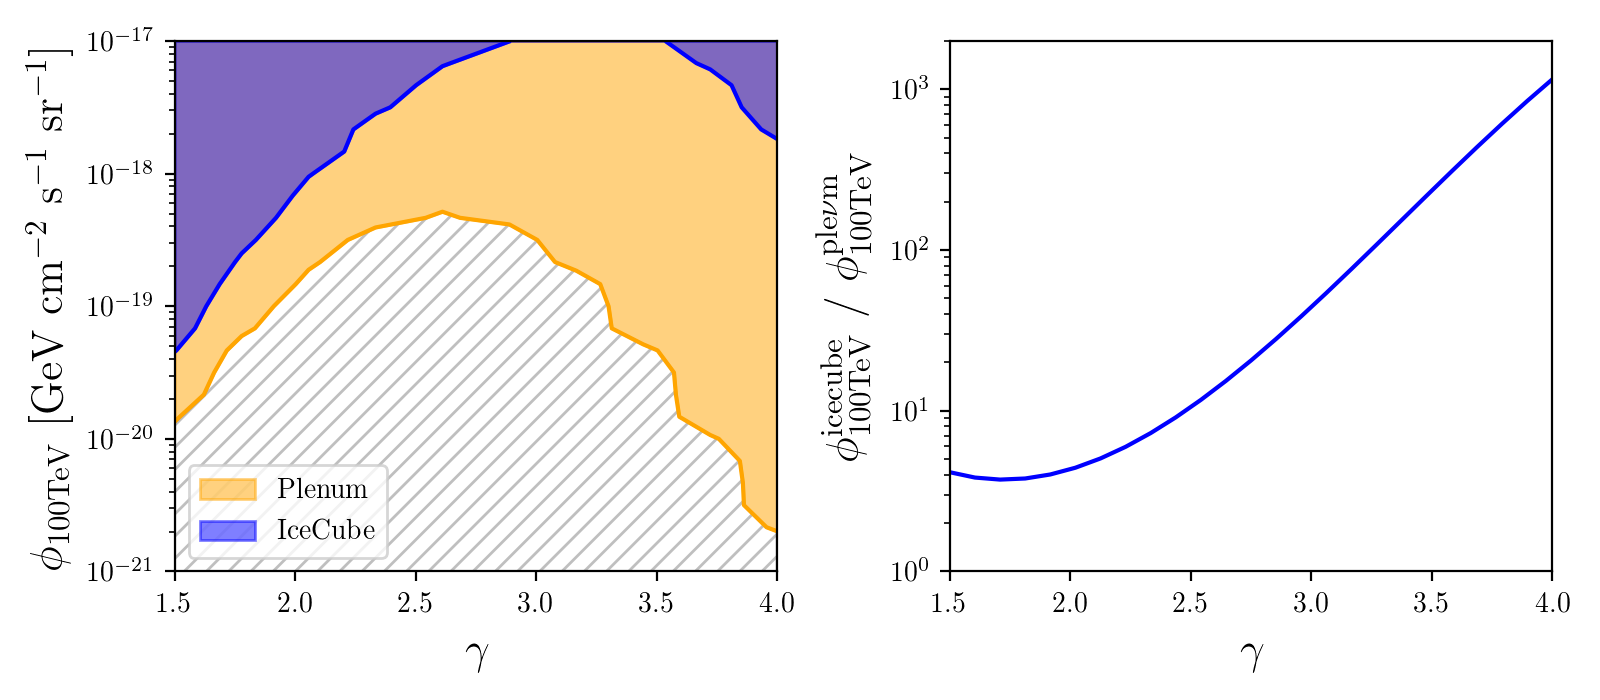

In [65]:
fig, axes = plt.subplots(ncols=2, figsize=(8,3.5))


ax = axes[0]
cs = ['blue','orange']
contours=dict()
for k, exp in enumerate(['icecube', 'plenum']):
    
    Fracs = Fractions[exp]
    
    ck = ax.contour( g_lims, phi_lims, Fracs, levels=[0.5], colors=[cs[k]])
    contours[exp] = ck
   
ax.set_yscale('log')
ax.set_ylabel(r'$\phi_{100\mathrm{TeV}}$ [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]', fontsize=16)
ax.set_xlabel(r'$\gamma$', fontsize=16)
ax.set_ylim(1e-21, 1e-17)

ax = axes[1]
ck_plenum = contours['plenum']
ck_path = ck_plenum.collections[0].get_paths()[0]
g_pl = ck_path.vertices[:,0]
phi_pl = ck_path.vertices[:,1]

ck_icecube = contours['icecube']

g_ice = []
phi_ice = []
for ck_path in ck_icecube.collections[0].get_paths():
    g_ice = np.append(g_ice,ck_path.vertices[:,0])
    phi_ice = np.append(phi_ice, ck_path.vertices[:,1])




g_vals = np.linspace(1.5,4,25)
tck_pl = splrep(g_pl, np.log(phi_pl) , s=1.e-0) 
tck_ice = splrep(g_ice, np.log(phi_ice) , s=1.e-0) 
#ax.plot(g_pl, phi_pl)
#ax.plot(g_vals, np.exp(splev( g_vals, tck_pl)))
#ax.plot(g_vals, np.exp(splev( g_vals, tck_ice)))
ax.plot(g_vals, np.exp(splev( g_vals, tck_ice)) / np.exp(splev( g_vals, tck_pl)) ,c='blue')

axes[0].fill_between(g_pl, phi_pl ,np.ones_like(g_pl)*1e-17, 
                     color='orange', alpha=0.5, label='Plenum')

axes[0].fill_between(g_pl, phi_pl ,np.ones_like(g_pl)*1e-21, 
                     edgecolor='grey', alpha=0.5, hatch='///', facecolor='none')

axes[0].fill_between(g_ice, phi_ice ,np.ones_like(g_ice)*1e-17, 
                     color='blue', alpha=0.5, label='IceCube')
axes[0].legend(loc='lower left')

#ax.plot(g_ice, phi_ice)
ax.set_ylabel(r'$\phi_{100\mathrm{TeV}}^{\mathrm{icecube}}$ / $\phi_{100\mathrm{TeV}}^{\mathrm{ple}\nu\mathrm{m}}$', fontsize=16)
ax.set_xlabel(r'$\gamma$', fontsize=16)
ax.set_xlim(gammas[0], gammas[-1])

ax.set_yscale('log')
ax.set_ylim(1,2e3)

fig.tight_layout()
fig.savefig('plots/discovery_region_galactic_center.pdf')